In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

In [3]:
# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

In [4]:
# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [5]:
# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in image.list_pictures(list_fams[i], ext='jpg|jpeg|bmp|png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

Processing images ...
Images processed: 9339


In [6]:
os.chdir(cur_dir)

In [7]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [8]:
# Creating base_model (VGG16 convolutional layers)
image_shape = (224, 224, 3)                                                                                                                                               
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False)         

In [9]:
filename = 'virussign-vgg16features.npy'
if os.path.exists(filename):
    print("Loading VGG16 extracted features from %s ..." %(filename))
    vggfeatures = np.load(filename)
else:
    print("Extracting features from VGG16 convolutional layers ...")
    vggfeatures = base_model.predict(X)
    print("Saving VGG16 extracted features into %s ..." %(filename))
    np.save(filename, vggfeatures)

Loading VGG16 extracted features from virussign-vgg16features.npy ...


In [10]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [11]:
# Training top_model and saving min training loss weights
num_epochs=1000
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='top_model-weights-min_loss-mlp-vgg16-2layers-160neurons-relu-0.4dropout-Adam-1000epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = vggfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = vggfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_model = Sequential() 
    top_model.add(Flatten(input_shape=base_model.output_shape[1:])) # input_shape=(7,7,512)                                                
    top_model.add(Dense(160, activation='relu', name='fc1'))
    top_model.add(Dropout(0.4))                
    top_model.add(Dense(160, activation='relu', name='fc2'))
    top_model.add(Dropout(0.4))              
    top_model.add(Dense(num_classes, activation='softmax', name='predictions'))                             
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/1000
8394/8394 [==============================] - 2s - loss: 14.4809 - acc: 0.0193 - val_loss: 6.3668 - val_acc: 0.5418
Epoch 2/1000
8394/8394 [==============================] - 1s - loss: 9.4380 - acc: 0.2840 - val_loss: 4.8716 - val_acc: 0.5926
Epoch 3/1000
8394/8394 [==============================] - 1s - loss: 6.5650 - acc: 0.5000 - val_loss: 2.5240 - val_acc: 0.8169
Epoch 4/1000
8394/8394 [==============================] - 1s - loss: 4.4677 - acc: 0.6371 - val_loss: 2.2530 - val_acc: 0.8233
Epoch 5/1000
8394/8394 [==============================] - 1s - loss: 3.5688 - acc: 0.7080 - val_loss: 1.9375 - val_acc: 0.8487
Epoch 6/1000
8394/8394 [==============================] - 1s - loss: 2.9476 - acc: 0.7561 - val_loss: 1.4670 - val_acc: 0.8720
Epoch 7/1000
8394/8394 [==============================] - 1s - loss: 2.5143 - acc: 0.7854 - val_loss: 1.0709 - val_acc: 0.9079
Epoch 8/1000
8394/8394 [==============================] - 1s - 

8394/8394 [==============================] - 1s - loss: 0.1305 - acc: 0.9705 - val_loss: 0.1306 - val_acc: 0.9852
Epoch 128/1000
8394/8394 [==============================] - 1s - loss: 0.1365 - acc: 0.9671 - val_loss: 0.1336 - val_acc: 0.9831
Epoch 129/1000
8394/8394 [==============================] - 1s - loss: 0.1275 - acc: 0.9725 - val_loss: 0.1363 - val_acc: 0.9725
Epoch 130/1000
8394/8394 [==============================] - 1s - loss: 0.1283 - acc: 0.9629 - val_loss: 0.1339 - val_acc: 0.9725
Epoch 131/1000
8394/8394 [==============================] - 1s - loss: 0.1326 - acc: 0.9643 - val_loss: 0.1359 - val_acc: 0.9820
Epoch 132/1000
8394/8394 [==============================] - 1s - loss: 0.1184 - acc: 0.9747 - val_loss: 0.1356 - val_acc: 0.9820
Epoch 133/1000
8394/8394 [==============================] - 1s - loss: 0.1332 - acc: 0.9706 - val_loss: 0.1310 - val_acc: 0.9820
Epoch 134/1000
8394/8394 [==============================] - 1s - loss: 0.1268 - acc: 0.9711 - val_loss: 0.1265 -

8394/8394 [==============================] - 1s - loss: 0.1026 - acc: 0.9761 - val_loss: 0.1342 - val_acc: 0.9820
Epoch 254/1000
8394/8394 [==============================] - 1s - loss: 0.1026 - acc: 0.9753 - val_loss: 0.1336 - val_acc: 0.9820
Epoch 255/1000
8394/8394 [==============================] - 1s - loss: 0.1012 - acc: 0.9774 - val_loss: 0.1316 - val_acc: 0.9831
Epoch 256/1000
8394/8394 [==============================] - 1s - loss: 0.0964 - acc: 0.9775 - val_loss: 0.1315 - val_acc: 0.9841
Epoch 257/1000
8394/8394 [==============================] - 1s - loss: 0.0926 - acc: 0.9782 - val_loss: 0.1313 - val_acc: 0.9841
Epoch 258/1000
8394/8394 [==============================] - 1s - loss: 0.0971 - acc: 0.9761 - val_loss: 0.1300 - val_acc: 0.9831
Epoch 259/1000
8394/8394 [==============================] - 1s - loss: 0.0985 - acc: 0.9770 - val_loss: 0.1315 - val_acc: 0.9704
Epoch 260/1000
8394/8394 [==============================] - 1s - loss: 0.1053 - acc: 0.9703 - val_loss: 0.1270 -

8394/8394 [==============================] - 1s - loss: 0.0967 - acc: 0.9709 - val_loss: 0.1230 - val_acc: 0.9831
Epoch 380/1000
8394/8394 [==============================] - 1s - loss: 0.0836 - acc: 0.9746 - val_loss: 0.1207 - val_acc: 0.9841
Epoch 381/1000
8394/8394 [==============================] - 1s - loss: 0.0925 - acc: 0.9714 - val_loss: 0.1185 - val_acc: 0.9841
Epoch 382/1000
8394/8394 [==============================] - 1s - loss: 0.0862 - acc: 0.9734 - val_loss: 0.1162 - val_acc: 0.9841
Epoch 383/1000
8394/8394 [==============================] - 1s - loss: 0.0894 - acc: 0.9724 - val_loss: 0.1138 - val_acc: 0.9862
Epoch 384/1000
8394/8394 [==============================] - 1s - loss: 0.0884 - acc: 0.9726 - val_loss: 0.1112 - val_acc: 0.9873
Epoch 385/1000
8394/8394 [==============================] - 1s - loss: 0.0903 - acc: 0.9720 - val_loss: 0.1115 - val_acc: 0.9884
Epoch 386/1000
8394/8394 [==============================] - 1s - loss: 0.0914 - acc: 0.9718 - val_loss: 0.1126 -

8394/8394 [==============================] - 1s - loss: 0.0757 - acc: 0.9746 - val_loss: 0.1442 - val_acc: 0.9820
Epoch 506/1000
8394/8394 [==============================] - 1s - loss: 0.0752 - acc: 0.9745 - val_loss: 0.1396 - val_acc: 0.9810
Epoch 507/1000
8394/8394 [==============================] - 1s - loss: 0.0809 - acc: 0.9728 - val_loss: 0.1337 - val_acc: 0.9841
Epoch 508/1000
8394/8394 [==============================] - 1s - loss: 0.0850 - acc: 0.9737 - val_loss: 0.1333 - val_acc: 0.9852
Epoch 509/1000
8394/8394 [==============================] - 1s - loss: 0.0831 - acc: 0.9727 - val_loss: 0.1339 - val_acc: 0.9852
Epoch 510/1000
8394/8394 [==============================] - 1s - loss: 0.0828 - acc: 0.9751 - val_loss: 0.1373 - val_acc: 0.9852
Epoch 511/1000
8394/8394 [==============================] - 1s - loss: 0.0715 - acc: 0.9749 - val_loss: 0.1436 - val_acc: 0.9841
Epoch 512/1000
8394/8394 [==============================] - 1s - loss: 0.0792 - acc: 0.9726 - val_loss: 0.1450 -

8394/8394 [==============================] - 1s - loss: 0.0723 - acc: 0.9750 - val_loss: 0.1164 - val_acc: 0.9746
Epoch 632/1000
8394/8394 [==============================] - 1s - loss: 0.0752 - acc: 0.9737 - val_loss: 0.1167 - val_acc: 0.9714
Epoch 633/1000
8394/8394 [==============================] - 1s - loss: 0.0642 - acc: 0.9770 - val_loss: 0.1196 - val_acc: 0.9735
Epoch 634/1000
8394/8394 [==============================] - 1s - loss: 0.0729 - acc: 0.9751 - val_loss: 0.1204 - val_acc: 0.9725
Epoch 635/1000
8394/8394 [==============================] - 1s - loss: 0.0704 - acc: 0.9753 - val_loss: 0.1199 - val_acc: 0.9714
Epoch 636/1000
8394/8394 [==============================] - 1s - loss: 0.0761 - acc: 0.9763 - val_loss: 0.1239 - val_acc: 0.9725
Epoch 637/1000
8394/8394 [==============================] - 1s - loss: 0.0748 - acc: 0.9749 - val_loss: 0.1207 - val_acc: 0.9735
Epoch 638/1000
8394/8394 [==============================] - 1s - loss: 0.0696 - acc: 0.9747 - val_loss: 0.1189 -

8394/8394 [==============================] - 1s - loss: 0.1090 - acc: 0.9730 - val_loss: 0.1095 - val_acc: 0.9778
Epoch 758/1000
8394/8394 [==============================] - 1s - loss: 0.0841 - acc: 0.9769 - val_loss: 0.1555 - val_acc: 0.9757
Epoch 759/1000
8394/8394 [==============================] - 1s - loss: 0.1132 - acc: 0.9776 - val_loss: 0.1543 - val_acc: 0.9757
Epoch 760/1000
8394/8394 [==============================] - 1s - loss: 0.1171 - acc: 0.9769 - val_loss: 0.1514 - val_acc: 0.9788
Epoch 761/1000
8394/8394 [==============================] - 1s - loss: 0.1181 - acc: 0.9761 - val_loss: 0.1487 - val_acc: 0.9788
Epoch 762/1000
8394/8394 [==============================] - 1s - loss: 0.1159 - acc: 0.9757 - val_loss: 0.1474 - val_acc: 0.9767
Epoch 763/1000
8394/8394 [==============================] - 1s - loss: 0.1120 - acc: 0.9761 - val_loss: 0.1454 - val_acc: 0.9788
Epoch 764/1000
8394/8394 [==============================] - 1s - loss: 0.1133 - acc: 0.9763 - val_loss: 0.1435 -

8394/8394 [==============================] - 1s - loss: 0.0961 - acc: 0.9777 - val_loss: 0.1364 - val_acc: 0.9767
Epoch 884/1000
8394/8394 [==============================] - 1s - loss: 0.0961 - acc: 0.9778 - val_loss: 0.1384 - val_acc: 0.9767
Epoch 885/1000
8394/8394 [==============================] - 1s - loss: 0.0950 - acc: 0.9761 - val_loss: 0.1401 - val_acc: 0.9778
Epoch 886/1000
8394/8394 [==============================] - 1s - loss: 0.0971 - acc: 0.9776 - val_loss: 0.1428 - val_acc: 0.9767
Epoch 887/1000
8394/8394 [==============================] - 1s - loss: 0.0858 - acc: 0.9795 - val_loss: 0.1487 - val_acc: 0.9757
Epoch 888/1000
8394/8394 [==============================] - 1s - loss: 0.0915 - acc: 0.9780 - val_loss: 0.1475 - val_acc: 0.9757
Epoch 889/1000
8394/8394 [==============================] - 1s - loss: 0.0922 - acc: 0.9772 - val_loss: 0.1443 - val_acc: 0.9757
Epoch 890/1000
8394/8394 [==============================] - 1s - loss: 0.1013 - acc: 0.9762 - val_loss: 0.1411 -

8397/8397 [==============================] - 1s - loss: 2.2946 - acc: 0.8208 - val_loss: 1.1077 - val_acc: 0.9183
Epoch 10/1000
8397/8397 [==============================] - 1s - loss: 2.1147 - acc: 0.8347 - val_loss: 1.0265 - val_acc: 0.9204
Epoch 11/1000
8397/8397 [==============================] - 1s - loss: 1.8371 - acc: 0.8540 - val_loss: 0.9357 - val_acc: 0.9289
Epoch 12/1000
8397/8397 [==============================] - 1s - loss: 1.6428 - acc: 0.8672 - val_loss: 0.8494 - val_acc: 0.9321
Epoch 13/1000
8397/8397 [==============================] - 1s - loss: 1.5335 - acc: 0.8719 - val_loss: 0.7979 - val_acc: 0.9416
Epoch 14/1000
8397/8397 [==============================] - 1s - loss: 1.3967 - acc: 0.8777 - val_loss: 0.7812 - val_acc: 0.9448
Epoch 15/1000
8397/8397 [==============================] - 1s - loss: 1.2638 - acc: 0.8878 - val_loss: 0.7453 - val_acc: 0.9480
Epoch 16/1000
8397/8397 [==============================] - 1s - loss: 1.1656 - acc: 0.8946 - val_loss: 0.7126 - val_ac

8397/8397 [==============================] - 1s - loss: 0.2328 - acc: 0.9769 - val_loss: 0.2533 - val_acc: 0.9777
Epoch 137/1000
8397/8397 [==============================] - 1s - loss: 0.2296 - acc: 0.9773 - val_loss: 0.2526 - val_acc: 0.9766
Epoch 138/1000
8397/8397 [==============================] - 1s - loss: 0.2284 - acc: 0.9784 - val_loss: 0.2521 - val_acc: 0.9766
Epoch 139/1000
8397/8397 [==============================] - 1s - loss: 0.2259 - acc: 0.9784 - val_loss: 0.2523 - val_acc: 0.9766
Epoch 140/1000
8397/8397 [==============================] - 1s - loss: 0.2280 - acc: 0.9780 - val_loss: 0.2537 - val_acc: 0.9766
Epoch 141/1000
8397/8397 [==============================] - 1s - loss: 0.2305 - acc: 0.9780 - val_loss: 0.2544 - val_acc: 0.9756
Epoch 142/1000
8397/8397 [==============================] - 1s - loss: 0.2315 - acc: 0.9771 - val_loss: 0.2543 - val_acc: 0.9756
Epoch 143/1000
8397/8397 [==============================] - 1s - loss: 0.2279 - acc: 0.9788 - val_loss: 0.2548 -

8397/8397 [==============================] - 1s - loss: 0.2096 - acc: 0.9826 - val_loss: 0.2725 - val_acc: 0.9777
Epoch 263/1000
8397/8397 [==============================] - 1s - loss: 0.2111 - acc: 0.9830 - val_loss: 0.2716 - val_acc: 0.9777
Epoch 264/1000
8397/8397 [==============================] - 1s - loss: 0.2133 - acc: 0.9836 - val_loss: 0.2708 - val_acc: 0.9777
Epoch 265/1000
8397/8397 [==============================] - 1s - loss: 0.2143 - acc: 0.9814 - val_loss: 0.2726 - val_acc: 0.9777
Epoch 266/1000
8397/8397 [==============================] - 1s - loss: 0.2105 - acc: 0.9830 - val_loss: 0.2749 - val_acc: 0.9777
Epoch 267/1000
8397/8397 [==============================] - 1s - loss: 0.2073 - acc: 0.9836 - val_loss: 0.2739 - val_acc: 0.9777
Epoch 268/1000
8397/8397 [==============================] - 1s - loss: 0.2094 - acc: 0.9829 - val_loss: 0.2716 - val_acc: 0.9766
Epoch 269/1000
8397/8397 [==============================] - 1s - loss: 0.2159 - acc: 0.9819 - val_loss: 0.2686 -

8397/8397 [==============================] - 1s - loss: 0.2056 - acc: 0.9851 - val_loss: 0.2731 - val_acc: 0.9756
Epoch 389/1000
8397/8397 [==============================] - 1s - loss: 0.2022 - acc: 0.9849 - val_loss: 0.2735 - val_acc: 0.9756
Epoch 390/1000
8397/8397 [==============================] - 1s - loss: 0.2040 - acc: 0.9851 - val_loss: 0.2730 - val_acc: 0.9756
Epoch 391/1000
8397/8397 [==============================] - 1s - loss: 0.2043 - acc: 0.9852 - val_loss: 0.2722 - val_acc: 0.9756
Epoch 392/1000
8397/8397 [==============================] - 1s - loss: 0.2037 - acc: 0.9852 - val_loss: 0.2714 - val_acc: 0.9756
Epoch 393/1000
8397/8397 [==============================] - 1s - loss: 0.2058 - acc: 0.9842 - val_loss: 0.2707 - val_acc: 0.9766
Epoch 394/1000
8397/8397 [==============================] - 1s - loss: 0.2073 - acc: 0.9839 - val_loss: 0.2701 - val_acc: 0.9766
Epoch 395/1000
8397/8397 [==============================] - 1s - loss: 0.2009 - acc: 0.9854 - val_loss: 0.2695 -

8397/8397 [==============================] - 1s - loss: 0.2014 - acc: 0.9852 - val_loss: 0.2633 - val_acc: 0.9777
Epoch 515/1000
8397/8397 [==============================] - 1s - loss: 0.2069 - acc: 0.9852 - val_loss: 0.2608 - val_acc: 0.9777
Epoch 516/1000
8397/8397 [==============================] - 1s - loss: 0.2046 - acc: 0.9855 - val_loss: 0.2603 - val_acc: 0.9777
Epoch 517/1000
8397/8397 [==============================] - 1s - loss: 0.2013 - acc: 0.9855 - val_loss: 0.2601 - val_acc: 0.9777
Epoch 518/1000
8397/8397 [==============================] - 1s - loss: 0.1998 - acc: 0.9851 - val_loss: 0.2609 - val_acc: 0.9777
Epoch 519/1000
8397/8397 [==============================] - 1s - loss: 0.2000 - acc: 0.9856 - val_loss: 0.2635 - val_acc: 0.9766
Epoch 520/1000
8397/8397 [==============================] - 1s - loss: 0.2056 - acc: 0.9840 - val_loss: 0.2670 - val_acc: 0.9777
Epoch 521/1000
8397/8397 [==============================] - 1s - loss: 0.2002 - acc: 0.9851 - val_loss: 0.2705 -

8397/8397 [==============================] - 1s - loss: 0.2004 - acc: 0.9859 - val_loss: 0.2723 - val_acc: 0.9756
Epoch 641/1000
8397/8397 [==============================] - 1s - loss: 0.1956 - acc: 0.9862 - val_loss: 0.2741 - val_acc: 0.9756
Epoch 642/1000
8397/8397 [==============================] - 1s - loss: 0.2039 - acc: 0.9848 - val_loss: 0.2712 - val_acc: 0.9756
Epoch 643/1000
8397/8397 [==============================] - 1s - loss: 0.1975 - acc: 0.9859 - val_loss: 0.2683 - val_acc: 0.9756
Epoch 644/1000
8397/8397 [==============================] - 1s - loss: 0.1992 - acc: 0.9855 - val_loss: 0.2661 - val_acc: 0.9766
Epoch 645/1000
8397/8397 [==============================] - 1s - loss: 0.1957 - acc: 0.9863 - val_loss: 0.2644 - val_acc: 0.9756
Epoch 646/1000
8397/8397 [==============================] - 1s - loss: 0.1952 - acc: 0.9863 - val_loss: 0.2639 - val_acc: 0.9756
Epoch 647/1000
8397/8397 [==============================] - 1s - loss: 0.1975 - acc: 0.9856 - val_loss: 0.2648 -

8397/8397 [==============================] - 1s - loss: 0.1992 - acc: 0.9857 - val_loss: 0.2776 - val_acc: 0.9777
Epoch 767/1000
8397/8397 [==============================] - 1s - loss: 0.1920 - acc: 0.9862 - val_loss: 0.2769 - val_acc: 0.9777
Epoch 768/1000
8397/8397 [==============================] - 1s - loss: 0.1944 - acc: 0.9864 - val_loss: 0.2768 - val_acc: 0.9777
Epoch 769/1000
8397/8397 [==============================] - 1s - loss: 0.1917 - acc: 0.9869 - val_loss: 0.2765 - val_acc: 0.9777
Epoch 770/1000
8397/8397 [==============================] - 1s - loss: 0.1961 - acc: 0.9861 - val_loss: 0.2761 - val_acc: 0.9777
Epoch 771/1000
8397/8397 [==============================] - 1s - loss: 0.1938 - acc: 0.9863 - val_loss: 0.2760 - val_acc: 0.9777
Epoch 772/1000
8397/8397 [==============================] - 1s - loss: 0.1971 - acc: 0.9854 - val_loss: 0.2740 - val_acc: 0.9777
Epoch 773/1000
8397/8397 [==============================] - 1s - loss: 0.1932 - acc: 0.9862 - val_loss: 0.2732 -

8397/8397 [==============================] - 1s - loss: 0.1930 - acc: 0.9864 - val_loss: 0.2628 - val_acc: 0.9777
Epoch 893/1000
8397/8397 [==============================] - 1s - loss: 0.1936 - acc: 0.9870 - val_loss: 0.2616 - val_acc: 0.9777
Epoch 894/1000
8397/8397 [==============================] - 1s - loss: 0.1944 - acc: 0.9868 - val_loss: 0.2623 - val_acc: 0.9777
Epoch 895/1000
8397/8397 [==============================] - 1s - loss: 0.1930 - acc: 0.9862 - val_loss: 0.2652 - val_acc: 0.9766
Epoch 896/1000
8397/8397 [==============================] - 1s - loss: 0.1922 - acc: 0.9871 - val_loss: 0.2685 - val_acc: 0.9766
Epoch 897/1000
8397/8397 [==============================] - 1s - loss: 0.1944 - acc: 0.9862 - val_loss: 0.2710 - val_acc: 0.9766
Epoch 898/1000
8397/8397 [==============================] - 1s - loss: 0.1925 - acc: 0.9863 - val_loss: 0.2738 - val_acc: 0.9766
Epoch 899/1000
8397/8397 [==============================] - 1s - loss: 0.1909 - acc: 0.9869 - val_loss: 0.2761 -

8401/8401 [==============================] - 1s - loss: 1.1238 - acc: 0.8888 - val_loss: 0.6836 - val_acc: 0.9424
Epoch 19/1000
8401/8401 [==============================] - 1s - loss: 1.0187 - acc: 0.8920 - val_loss: 0.6727 - val_acc: 0.9424
Epoch 20/1000
8401/8401 [==============================] - 1s - loss: 1.0044 - acc: 0.8916 - val_loss: 0.6791 - val_acc: 0.9371
Epoch 21/1000
8401/8401 [==============================] - 1s - loss: 0.9463 - acc: 0.8905 - val_loss: 0.6856 - val_acc: 0.9350
Epoch 22/1000
8401/8401 [==============================] - 1s - loss: 0.9168 - acc: 0.8911 - val_loss: 0.6787 - val_acc: 0.9307
Epoch 23/1000
8401/8401 [==============================] - 1s - loss: 0.8641 - acc: 0.8917 - val_loss: 0.6684 - val_acc: 0.9318
Epoch 24/1000
8401/8401 [==============================] - 1s - loss: 0.8407 - acc: 0.8928 - val_loss: 0.6465 - val_acc: 0.9307
Epoch 25/1000
8401/8401 [==============================] - 1s - loss: 0.8110 - acc: 0.8962 - val_loss: 0.6145 - val_ac

8401/8401 [==============================] - 1s - loss: 0.3038 - acc: 0.9616 - val_loss: 0.3205 - val_acc: 0.9638
Epoch 146/1000
8401/8401 [==============================] - 1s - loss: 0.3007 - acc: 0.9606 - val_loss: 0.3224 - val_acc: 0.9627
Epoch 147/1000
8401/8401 [==============================] - 1s - loss: 0.2996 - acc: 0.9623 - val_loss: 0.3258 - val_acc: 0.9638
Epoch 148/1000
8401/8401 [==============================] - 1s - loss: 0.3119 - acc: 0.9589 - val_loss: 0.3221 - val_acc: 0.9616
Epoch 149/1000
8401/8401 [==============================] - 1s - loss: 0.3030 - acc: 0.9612 - val_loss: 0.3201 - val_acc: 0.9627
Epoch 150/1000
8401/8401 [==============================] - 1s - loss: 0.2981 - acc: 0.9623 - val_loss: 0.3190 - val_acc: 0.9627
Epoch 151/1000
8401/8401 [==============================] - 1s - loss: 0.2959 - acc: 0.9617 - val_loss: 0.3192 - val_acc: 0.9638
Epoch 152/1000
8401/8401 [==============================] - 1s - loss: 0.3042 - acc: 0.9604 - val_loss: 0.3190 -

8401/8401 [==============================] - 1s - loss: 0.2465 - acc: 0.9743 - val_loss: 0.2651 - val_acc: 0.9776
Epoch 272/1000
8401/8401 [==============================] - 1s - loss: 0.2433 - acc: 0.9735 - val_loss: 0.2656 - val_acc: 0.9787
Epoch 273/1000
8401/8401 [==============================] - 1s - loss: 0.2442 - acc: 0.9735 - val_loss: 0.2657 - val_acc: 0.9787
Epoch 274/1000
8401/8401 [==============================] - 1s - loss: 0.2401 - acc: 0.9752 - val_loss: 0.2692 - val_acc: 0.9787
Epoch 275/1000
8401/8401 [==============================] - 1s - loss: 0.2405 - acc: 0.9756 - val_loss: 0.2694 - val_acc: 0.9787
Epoch 276/1000
8401/8401 [==============================] - 1s - loss: 0.2421 - acc: 0.9748 - val_loss: 0.2677 - val_acc: 0.9787
Epoch 277/1000
8401/8401 [==============================] - 1s - loss: 0.2453 - acc: 0.9731 - val_loss: 0.2681 - val_acc: 0.9797
Epoch 278/1000
8401/8401 [==============================] - 1s - loss: 0.2387 - acc: 0.9749 - val_loss: 0.2695 -

8401/8401 [==============================] - 1s - loss: 0.2217 - acc: 0.9775 - val_loss: 0.2621 - val_acc: 0.9797
Epoch 398/1000
8401/8401 [==============================] - 1s - loss: 0.2206 - acc: 0.9779 - val_loss: 0.2668 - val_acc: 0.9797
Epoch 399/1000
8401/8401 [==============================] - 1s - loss: 0.2241 - acc: 0.9775 - val_loss: 0.2654 - val_acc: 0.9808
Epoch 400/1000
8401/8401 [==============================] - 1s - loss: 0.2214 - acc: 0.9774 - val_loss: 0.2639 - val_acc: 0.9797
Epoch 401/1000
8401/8401 [==============================] - 1s - loss: 0.2285 - acc: 0.9769 - val_loss: 0.2639 - val_acc: 0.9797
Epoch 402/1000
8401/8401 [==============================] - 1s - loss: 0.2260 - acc: 0.9769 - val_loss: 0.2632 - val_acc: 0.9797
Epoch 403/1000
8401/8401 [==============================] - 1s - loss: 0.2274 - acc: 0.9771 - val_loss: 0.2636 - val_acc: 0.9787
Epoch 404/1000
8401/8401 [==============================] - 1s - loss: 0.2248 - acc: 0.9771 - val_loss: 0.2619 -

8401/8401 [==============================] - 1s - loss: 0.2146 - acc: 0.9789 - val_loss: 0.2577 - val_acc: 0.9787
Epoch 524/1000
8401/8401 [==============================] - 1s - loss: 0.2222 - acc: 0.9769 - val_loss: 0.2580 - val_acc: 0.9787
Epoch 525/1000
8401/8401 [==============================] - 1s - loss: 0.2104 - acc: 0.9802 - val_loss: 0.2598 - val_acc: 0.9776
Epoch 526/1000
8401/8401 [==============================] - 1s - loss: 0.2149 - acc: 0.9796 - val_loss: 0.2605 - val_acc: 0.9776
Epoch 527/1000
8401/8401 [==============================] - 1s - loss: 0.2160 - acc: 0.9793 - val_loss: 0.2606 - val_acc: 0.9776
Epoch 528/1000
8401/8401 [==============================] - 1s - loss: 0.2169 - acc: 0.9776 - val_loss: 0.2600 - val_acc: 0.9787
Epoch 529/1000
8401/8401 [==============================] - 1s - loss: 0.2162 - acc: 0.9781 - val_loss: 0.2605 - val_acc: 0.9797
Epoch 530/1000
8401/8401 [==============================] - 1s - loss: 0.2150 - acc: 0.9787 - val_loss: 0.2624 -

8401/8401 [==============================] - 1s - loss: 0.2131 - acc: 0.9794 - val_loss: 0.2617 - val_acc: 0.9765
Epoch 650/1000
8401/8401 [==============================] - 1s - loss: 0.2103 - acc: 0.9791 - val_loss: 0.2653 - val_acc: 0.9776
Epoch 651/1000
8401/8401 [==============================] - 1s - loss: 0.2099 - acc: 0.9800 - val_loss: 0.2651 - val_acc: 0.9776
Epoch 652/1000
8401/8401 [==============================] - 1s - loss: 0.2163 - acc: 0.9780 - val_loss: 0.2601 - val_acc: 0.9776
Epoch 653/1000
8401/8401 [==============================] - 1s - loss: 0.2146 - acc: 0.9792 - val_loss: 0.2561 - val_acc: 0.9765
Epoch 654/1000
8401/8401 [==============================] - 1s - loss: 0.2127 - acc: 0.9787 - val_loss: 0.2552 - val_acc: 0.9776
Epoch 655/1000
8401/8401 [==============================] - 1s - loss: 0.2148 - acc: 0.9793 - val_loss: 0.2550 - val_acc: 0.9787
Epoch 656/1000
8401/8401 [==============================] - 1s - loss: 0.2095 - acc: 0.9796 - val_loss: 0.2553 -

8401/8401 [==============================] - 1s - loss: 0.2071 - acc: 0.9808 - val_loss: 0.2541 - val_acc: 0.9776
Epoch 776/1000
8401/8401 [==============================] - 1s - loss: 0.2150 - acc: 0.9781 - val_loss: 0.2552 - val_acc: 0.9797
Epoch 777/1000
8401/8401 [==============================] - 1s - loss: 0.2151 - acc: 0.9793 - val_loss: 0.2552 - val_acc: 0.9787
Epoch 778/1000
8401/8401 [==============================] - 1s - loss: 0.2102 - acc: 0.9798 - val_loss: 0.2551 - val_acc: 0.9797
Epoch 779/1000
8401/8401 [==============================] - 1s - loss: 0.2100 - acc: 0.9796 - val_loss: 0.2562 - val_acc: 0.9787
Epoch 780/1000
8401/8401 [==============================] - 1s - loss: 0.2136 - acc: 0.9785 - val_loss: 0.2571 - val_acc: 0.9776
Epoch 781/1000
8401/8401 [==============================] - 1s - loss: 0.2132 - acc: 0.9787 - val_loss: 0.2573 - val_acc: 0.9776
Epoch 782/1000
8401/8401 [==============================] - 1s - loss: 0.2091 - acc: 0.9805 - val_loss: 0.2570 -

8401/8401 [==============================] - 1s - loss: 0.2109 - acc: 0.9796 - val_loss: 0.2611 - val_acc: 0.9765
Epoch 902/1000
8401/8401 [==============================] - 1s - loss: 0.2089 - acc: 0.9796 - val_loss: 0.2631 - val_acc: 0.9755
Epoch 903/1000
8401/8401 [==============================] - 1s - loss: 0.2092 - acc: 0.9793 - val_loss: 0.2655 - val_acc: 0.9755
Epoch 904/1000
8401/8401 [==============================] - 1s - loss: 0.2160 - acc: 0.9791 - val_loss: 0.2682 - val_acc: 0.9755
Epoch 905/1000
8401/8401 [==============================] - 1s - loss: 0.2111 - acc: 0.9799 - val_loss: 0.2699 - val_acc: 0.9765
Epoch 906/1000
8401/8401 [==============================] - 1s - loss: 0.2138 - acc: 0.9802 - val_loss: 0.2689 - val_acc: 0.9765
Epoch 907/1000
8401/8401 [==============================] - 1s - loss: 0.2076 - acc: 0.9796 - val_loss: 0.2656 - val_acc: 0.9755
Epoch 908/1000
8401/8401 [==============================] - 1s - loss: 0.2127 - acc: 0.9792 - val_loss: 0.2635 -

8403/8403 [==============================] - 1s - loss: 0.6261 - acc: 0.8928 - val_loss: 0.5359 - val_acc: 0.9241
Epoch 28/1000
8403/8403 [==============================] - 1s - loss: 0.6050 - acc: 0.8962 - val_loss: 0.5348 - val_acc: 0.9241
Epoch 29/1000
8403/8403 [==============================] - 1s - loss: 0.5889 - acc: 0.9000 - val_loss: 0.5338 - val_acc: 0.9241
Epoch 30/1000
8403/8403 [==============================] - 1s - loss: 0.5879 - acc: 0.8993 - val_loss: 0.5324 - val_acc: 0.9241
Epoch 31/1000
8403/8403 [==============================] - 1s - loss: 0.5813 - acc: 0.9005 - val_loss: 0.5297 - val_acc: 0.9252
Epoch 32/1000
8403/8403 [==============================] - 1s - loss: 0.5593 - acc: 0.9069 - val_loss: 0.5247 - val_acc: 0.9295
Epoch 33/1000
8403/8403 [==============================] - 1s - loss: 0.5489 - acc: 0.9066 - val_loss: 0.5145 - val_acc: 0.9306
Epoch 34/1000
8403/8403 [==============================] - 1s - loss: 0.5555 - acc: 0.9090 - val_loss: 0.5020 - val_ac

8403/8403 [==============================] - 1s - loss: 0.3177 - acc: 0.9625 - val_loss: 0.2884 - val_acc: 0.9808
Epoch 155/1000
8403/8403 [==============================] - 1s - loss: 0.3133 - acc: 0.9636 - val_loss: 0.2884 - val_acc: 0.9808
Epoch 156/1000
8403/8403 [==============================] - 1s - loss: 0.3120 - acc: 0.9636 - val_loss: 0.2892 - val_acc: 0.9808
Epoch 157/1000
8403/8403 [==============================] - 1s - loss: 0.3105 - acc: 0.9644 - val_loss: 0.2902 - val_acc: 0.9808
Epoch 158/1000
8403/8403 [==============================] - 1s - loss: 0.3101 - acc: 0.9632 - val_loss: 0.2902 - val_acc: 0.9808
Epoch 159/1000
8403/8403 [==============================] - 1s - loss: 0.3023 - acc: 0.9656 - val_loss: 0.2902 - val_acc: 0.9808
Epoch 160/1000
8403/8403 [==============================] - 1s - loss: 0.3028 - acc: 0.9647 - val_loss: 0.2902 - val_acc: 0.9808
Epoch 161/1000
8403/8403 [==============================] - 1s - loss: 0.3090 - acc: 0.9643 - val_loss: 0.2897 -

8403/8403 [==============================] - 1s - loss: 0.2666 - acc: 0.9701 - val_loss: 0.2732 - val_acc: 0.9786
Epoch 281/1000
8403/8403 [==============================] - 1s - loss: 0.2636 - acc: 0.9711 - val_loss: 0.2755 - val_acc: 0.9786
Epoch 282/1000
8403/8403 [==============================] - 1s - loss: 0.2668 - acc: 0.9706 - val_loss: 0.2742 - val_acc: 0.9797
Epoch 283/1000
8403/8403 [==============================] - 1s - loss: 0.2754 - acc: 0.9676 - val_loss: 0.2696 - val_acc: 0.9818
Epoch 284/1000
8403/8403 [==============================] - 1s - loss: 0.2638 - acc: 0.9713 - val_loss: 0.2664 - val_acc: 0.9818
Epoch 285/1000
8403/8403 [==============================] - 1s - loss: 0.2708 - acc: 0.9679 - val_loss: 0.2650 - val_acc: 0.9808
Epoch 286/1000
8403/8403 [==============================] - 1s - loss: 0.2714 - acc: 0.9689 - val_loss: 0.2674 - val_acc: 0.9808
Epoch 287/1000
8403/8403 [==============================] - 1s - loss: 0.2695 - acc: 0.9689 - val_loss: 0.2701 -

8403/8403 [==============================] - 1s - loss: 0.2480 - acc: 0.9711 - val_loss: 0.2538 - val_acc: 0.9818
Epoch 407/1000
8403/8403 [==============================] - 1s - loss: 0.2527 - acc: 0.9705 - val_loss: 0.2548 - val_acc: 0.9818
Epoch 408/1000
8403/8403 [==============================] - 1s - loss: 0.2499 - acc: 0.9705 - val_loss: 0.2559 - val_acc: 0.9797
Epoch 409/1000
8403/8403 [==============================] - 1s - loss: 0.2498 - acc: 0.9717 - val_loss: 0.2561 - val_acc: 0.9797
Epoch 410/1000
8403/8403 [==============================] - 1s - loss: 0.2552 - acc: 0.9704 - val_loss: 0.2584 - val_acc: 0.9808
Epoch 411/1000
8403/8403 [==============================] - 1s - loss: 0.2505 - acc: 0.9704 - val_loss: 0.2596 - val_acc: 0.9808
Epoch 412/1000
8403/8403 [==============================] - 1s - loss: 0.2454 - acc: 0.9718 - val_loss: 0.2576 - val_acc: 0.9818
Epoch 413/1000
8403/8403 [==============================] - 1s - loss: 0.2453 - acc: 0.9730 - val_loss: 0.2570 -

8403/8403 [==============================] - 1s - loss: 0.2447 - acc: 0.9719 - val_loss: 0.2500 - val_acc: 0.9797
Epoch 533/1000
8403/8403 [==============================] - 1s - loss: 0.2388 - acc: 0.9736 - val_loss: 0.2484 - val_acc: 0.9818
Epoch 534/1000
8403/8403 [==============================] - 1s - loss: 0.2376 - acc: 0.9719 - val_loss: 0.2478 - val_acc: 0.9818
Epoch 535/1000
8403/8403 [==============================] - 1s - loss: 0.2461 - acc: 0.9716 - val_loss: 0.2476 - val_acc: 0.9818
Epoch 536/1000
8403/8403 [==============================] - 1s - loss: 0.2392 - acc: 0.9729 - val_loss: 0.2474 - val_acc: 0.9818
Epoch 537/1000
8403/8403 [==============================] - 1s - loss: 0.2314 - acc: 0.9752 - val_loss: 0.2482 - val_acc: 0.9818
Epoch 538/1000
8403/8403 [==============================] - 1s - loss: 0.2445 - acc: 0.9706 - val_loss: 0.2483 - val_acc: 0.9818
Epoch 539/1000
8403/8403 [==============================] - 1s - loss: 0.2431 - acc: 0.9719 - val_loss: 0.2487 -

8403/8403 [==============================] - 1s - loss: 0.2385 - acc: 0.9735 - val_loss: 0.2463 - val_acc: 0.9818
Epoch 659/1000
8403/8403 [==============================] - 1s - loss: 0.2380 - acc: 0.9724 - val_loss: 0.2460 - val_acc: 0.9818
Epoch 660/1000
8403/8403 [==============================] - 1s - loss: 0.2384 - acc: 0.9729 - val_loss: 0.2469 - val_acc: 0.9818
Epoch 661/1000
8403/8403 [==============================] - 1s - loss: 0.2405 - acc: 0.9719 - val_loss: 0.2482 - val_acc: 0.9818
Epoch 662/1000
8403/8403 [==============================] - 1s - loss: 0.2432 - acc: 0.9713 - val_loss: 0.2482 - val_acc: 0.9818
Epoch 663/1000
8403/8403 [==============================] - 1s - loss: 0.2403 - acc: 0.9712 - val_loss: 0.2491 - val_acc: 0.9818
Epoch 664/1000
8403/8403 [==============================] - 1s - loss: 0.2373 - acc: 0.9732 - val_loss: 0.2485 - val_acc: 0.9829
Epoch 665/1000
8403/8403 [==============================] - 1s - loss: 0.2401 - acc: 0.9717 - val_loss: 0.2484 -

8403/8403 [==============================] - 1s - loss: 0.2370 - acc: 0.9732 - val_loss: 0.2614 - val_acc: 0.9818
Epoch 785/1000
8403/8403 [==============================] - 1s - loss: 0.2376 - acc: 0.9719 - val_loss: 0.2594 - val_acc: 0.9829
Epoch 786/1000
8403/8403 [==============================] - 1s - loss: 0.2360 - acc: 0.9739 - val_loss: 0.2577 - val_acc: 0.9829
Epoch 787/1000
8403/8403 [==============================] - 1s - loss: 0.2340 - acc: 0.9745 - val_loss: 0.2576 - val_acc: 0.9818
Epoch 788/1000
8403/8403 [==============================] - 1s - loss: 0.2342 - acc: 0.9742 - val_loss: 0.2581 - val_acc: 0.9818
Epoch 789/1000
8403/8403 [==============================] - 1s - loss: 0.2413 - acc: 0.9730 - val_loss: 0.2588 - val_acc: 0.9818
Epoch 790/1000
8403/8403 [==============================] - 1s - loss: 0.2345 - acc: 0.9738 - val_loss: 0.2593 - val_acc: 0.9818
Epoch 791/1000
8403/8403 [==============================] - 1s - loss: 0.2315 - acc: 0.9749 - val_loss: 0.2591 -

8403/8403 [==============================] - 1s - loss: 0.2352 - acc: 0.9723 - val_loss: 0.2539 - val_acc: 0.9797
Epoch 911/1000
8403/8403 [==============================] - 1s - loss: 0.2403 - acc: 0.9720 - val_loss: 0.2516 - val_acc: 0.9808
Epoch 912/1000
8403/8403 [==============================] - 1s - loss: 0.2385 - acc: 0.9725 - val_loss: 0.2519 - val_acc: 0.9818
Epoch 913/1000
8403/8403 [==============================] - 1s - loss: 0.2466 - acc: 0.9705 - val_loss: 0.2527 - val_acc: 0.9818
Epoch 914/1000
8403/8403 [==============================] - 1s - loss: 0.2389 - acc: 0.9730 - val_loss: 0.2537 - val_acc: 0.9818
Epoch 915/1000
8403/8403 [==============================] - 1s - loss: 0.2447 - acc: 0.9699 - val_loss: 0.2588 - val_acc: 0.9797
Epoch 916/1000
8403/8403 [==============================] - 1s - loss: 0.2337 - acc: 0.9727 - val_loss: 0.2587 - val_acc: 0.9786
Epoch 917/1000
8403/8403 [==============================] - 1s - loss: 0.2453 - acc: 0.9697 - val_loss: 0.2542 -

8404/8404 [==============================] - 1s - loss: 0.4011 - acc: 0.9343 - val_loss: 0.2767 - val_acc: 0.9711
Epoch 37/1000
8404/8404 [==============================] - 1s - loss: 0.4132 - acc: 0.9337 - val_loss: 0.2749 - val_acc: 0.9701
Epoch 38/1000
8404/8404 [==============================] - 1s - loss: 0.3965 - acc: 0.9367 - val_loss: 0.2751 - val_acc: 0.9701
Epoch 39/1000
8404/8404 [==============================] - 1s - loss: 0.3795 - acc: 0.9369 - val_loss: 0.2703 - val_acc: 0.9679
Epoch 40/1000
8404/8404 [==============================] - 1s - loss: 0.3628 - acc: 0.9434 - val_loss: 0.2663 - val_acc: 0.9701
Epoch 41/1000
8404/8404 [==============================] - 1s - loss: 0.3662 - acc: 0.9442 - val_loss: 0.2610 - val_acc: 0.9690
Epoch 42/1000
8404/8404 [==============================] - 1s - loss: 0.3593 - acc: 0.9435 - val_loss: 0.2580 - val_acc: 0.9658
Epoch 43/1000
8404/8404 [==============================] - 1s - loss: 0.3479 - acc: 0.9462 - val_loss: 0.2560 - val_ac

8404/8404 [==============================] - 1s - loss: 0.2529 - acc: 0.9728 - val_loss: 0.2714 - val_acc: 0.9711
Epoch 101/1000
8404/8404 [==============================] - 1s - loss: 0.2418 - acc: 0.9731 - val_loss: 0.2675 - val_acc: 0.9711
Epoch 102/1000
8404/8404 [==============================] - 1s - loss: 0.2445 - acc: 0.9748 - val_loss: 0.2635 - val_acc: 0.9711
Epoch 103/1000
8404/8404 [==============================] - 1s - loss: 0.2396 - acc: 0.9739 - val_loss: 0.2631 - val_acc: 0.9701
Epoch 104/1000
8404/8404 [==============================] - 1s - loss: 0.2477 - acc: 0.9745 - val_loss: 0.2664 - val_acc: 0.9701
Epoch 105/1000
8404/8404 [==============================] - 1s - loss: 0.2426 - acc: 0.9749 - val_loss: 0.2699 - val_acc: 0.9701
Epoch 106/1000
8404/8404 [==============================] - 1s - loss: 0.2428 - acc: 0.9741 - val_loss: 0.2734 - val_acc: 0.9690
Epoch 107/1000
8404/8404 [==============================] - 1s - loss: 0.2460 - acc: 0.9733 - val_loss: 0.2745 -

8404/8404 [==============================] - 1s - loss: 0.2153 - acc: 0.9805 - val_loss: 0.2727 - val_acc: 0.9690
Epoch 227/1000
8404/8404 [==============================] - 1s - loss: 0.2180 - acc: 0.9805 - val_loss: 0.2737 - val_acc: 0.9701
Epoch 228/1000
8404/8404 [==============================] - 1s - loss: 0.2176 - acc: 0.9807 - val_loss: 0.2778 - val_acc: 0.9701
Epoch 229/1000
8404/8404 [==============================] - 1s - loss: 0.2158 - acc: 0.9816 - val_loss: 0.2830 - val_acc: 0.9711
Epoch 230/1000
8404/8404 [==============================] - 1s - loss: 0.2149 - acc: 0.9814 - val_loss: 0.2871 - val_acc: 0.9711
Epoch 231/1000
8404/8404 [==============================] - 1s - loss: 0.2205 - acc: 0.9805 - val_loss: 0.2869 - val_acc: 0.9701
Epoch 232/1000
8404/8404 [==============================] - 1s - loss: 0.2214 - acc: 0.9805 - val_loss: 0.2873 - val_acc: 0.9701
Epoch 233/1000
8404/8404 [==============================] - 1s - loss: 0.2239 - acc: 0.9780 - val_loss: 0.2850 -

8404/8404 [==============================] - 1s - loss: 0.2116 - acc: 0.9816 - val_loss: 0.2975 - val_acc: 0.9711
Epoch 353/1000
8404/8404 [==============================] - 1s - loss: 0.2171 - acc: 0.9816 - val_loss: 0.2996 - val_acc: 0.9701
Epoch 354/1000
8404/8404 [==============================] - 1s - loss: 0.2071 - acc: 0.9818 - val_loss: 0.2967 - val_acc: 0.9701
Epoch 355/1000
8404/8404 [==============================] - 1s - loss: 0.2066 - acc: 0.9835 - val_loss: 0.2941 - val_acc: 0.9690
Epoch 356/1000
8404/8404 [==============================] - 1s - loss: 0.2094 - acc: 0.9824 - val_loss: 0.2943 - val_acc: 0.9690
Epoch 357/1000
8404/8404 [==============================] - 1s - loss: 0.2132 - acc: 0.9818 - val_loss: 0.2956 - val_acc: 0.9690
Epoch 358/1000
8404/8404 [==============================] - 1s - loss: 0.2070 - acc: 0.9841 - val_loss: 0.2957 - val_acc: 0.9701
Epoch 359/1000
8404/8404 [==============================] - 1s - loss: 0.2093 - acc: 0.9825 - val_loss: 0.2949 -

8404/8404 [==============================] - 1s - loss: 0.2093 - acc: 0.9835 - val_loss: 0.3179 - val_acc: 0.9711
Epoch 479/1000
8404/8404 [==============================] - 1s - loss: 0.2064 - acc: 0.9833 - val_loss: 0.3152 - val_acc: 0.9711
Epoch 480/1000
8404/8404 [==============================] - 1s - loss: 0.2034 - acc: 0.9849 - val_loss: 0.3122 - val_acc: 0.9701
Epoch 481/1000
8404/8404 [==============================] - 1s - loss: 0.2063 - acc: 0.9838 - val_loss: 0.3121 - val_acc: 0.9690
Epoch 482/1000
8404/8404 [==============================] - 1s - loss: 0.2057 - acc: 0.9830 - val_loss: 0.3137 - val_acc: 0.9690
Epoch 483/1000
8404/8404 [==============================] - 1s - loss: 0.2062 - acc: 0.9833 - val_loss: 0.3139 - val_acc: 0.9701
Epoch 484/1000
8404/8404 [==============================] - 1s - loss: 0.2046 - acc: 0.9836 - val_loss: 0.3142 - val_acc: 0.9701
Epoch 485/1000
8404/8404 [==============================] - 1s - loss: 0.2049 - acc: 0.9835 - val_loss: 0.3138 -

8404/8404 [==============================] - 1s - loss: 0.2023 - acc: 0.9848 - val_loss: 0.3057 - val_acc: 0.9701
Epoch 605/1000
8404/8404 [==============================] - 1s - loss: 0.2016 - acc: 0.9841 - val_loss: 0.2964 - val_acc: 0.9690
Epoch 606/1000
8404/8404 [==============================] - 1s - loss: 0.2008 - acc: 0.9843 - val_loss: 0.2867 - val_acc: 0.9690
Epoch 607/1000
8404/8404 [==============================] - 1s - loss: 0.2037 - acc: 0.9839 - val_loss: 0.2801 - val_acc: 0.9701
Epoch 608/1000
8404/8404 [==============================] - 1s - loss: 0.2037 - acc: 0.9842 - val_loss: 0.2773 - val_acc: 0.9701
Epoch 609/1000
8404/8404 [==============================] - 1s - loss: 0.2035 - acc: 0.9844 - val_loss: 0.2771 - val_acc: 0.9701
Epoch 610/1000
8404/8404 [==============================] - 1s - loss: 0.2067 - acc: 0.9844 - val_loss: 0.2803 - val_acc: 0.9701
Epoch 611/1000
8404/8404 [==============================] - 1s - loss: 0.2027 - acc: 0.9852 - val_loss: 0.2881 -

8404/8404 [==============================] - 1s - loss: 0.2009 - acc: 0.9845 - val_loss: 0.3045 - val_acc: 0.9690
Epoch 731/1000
8404/8404 [==============================] - 1s - loss: 0.1988 - acc: 0.9852 - val_loss: 0.3002 - val_acc: 0.9711
Epoch 732/1000
8404/8404 [==============================] - 1s - loss: 0.2006 - acc: 0.9855 - val_loss: 0.2983 - val_acc: 0.9711
Epoch 733/1000
8404/8404 [==============================] - 1s - loss: 0.1997 - acc: 0.9848 - val_loss: 0.2988 - val_acc: 0.9711
Epoch 734/1000
8404/8404 [==============================] - 1s - loss: 0.2018 - acc: 0.9843 - val_loss: 0.2997 - val_acc: 0.9711
Epoch 735/1000
8404/8404 [==============================] - 1s - loss: 0.2027 - acc: 0.9844 - val_loss: 0.3014 - val_acc: 0.9711
Epoch 736/1000
8404/8404 [==============================] - 1s - loss: 0.2038 - acc: 0.9844 - val_loss: 0.3037 - val_acc: 0.9711
Epoch 737/1000
8404/8404 [==============================] - 1s - loss: 0.2013 - acc: 0.9850 - val_loss: 0.3087 -

8404/8404 [==============================] - 1s - loss: 0.1971 - acc: 0.9861 - val_loss: 0.3034 - val_acc: 0.9701
Epoch 857/1000
8404/8404 [==============================] - 1s - loss: 0.2006 - acc: 0.9848 - val_loss: 0.3033 - val_acc: 0.9701
Epoch 858/1000
8404/8404 [==============================] - 1s - loss: 0.1971 - acc: 0.9856 - val_loss: 0.3039 - val_acc: 0.9711
Epoch 859/1000
8404/8404 [==============================] - 1s - loss: 0.1957 - acc: 0.9862 - val_loss: 0.3033 - val_acc: 0.9711
Epoch 860/1000
8404/8404 [==============================] - 1s - loss: 0.2003 - acc: 0.9858 - val_loss: 0.3037 - val_acc: 0.9701
Epoch 861/1000
8404/8404 [==============================] - 1s - loss: 0.2021 - acc: 0.9857 - val_loss: 0.3047 - val_acc: 0.9701
Epoch 862/1000
8404/8404 [==============================] - 1s - loss: 0.1965 - acc: 0.9857 - val_loss: 0.3068 - val_acc: 0.9701
Epoch 863/1000
8404/8404 [==============================] - 1s - loss: 0.1989 - acc: 0.9854 - val_loss: 0.3091 -

8404/8404 [==============================] - 1s - loss: 0.2008 - acc: 0.9857 - val_loss: 0.3166 - val_acc: 0.9690
Epoch 983/1000
8404/8404 [==============================] - 1s - loss: 0.1945 - acc: 0.9868 - val_loss: 0.3148 - val_acc: 0.9690
Epoch 984/1000
8404/8404 [==============================] - 1s - loss: 0.1993 - acc: 0.9854 - val_loss: 0.3153 - val_acc: 0.9690
Epoch 985/1000
8404/8404 [==============================] - 1s - loss: 0.1991 - acc: 0.9851 - val_loss: 0.3144 - val_acc: 0.9701
Epoch 986/1000
8404/8404 [==============================] - 1s - loss: 0.1979 - acc: 0.9851 - val_loss: 0.3134 - val_acc: 0.9701
Epoch 987/1000
8404/8404 [==============================] - 1s - loss: 0.1965 - acc: 0.9858 - val_loss: 0.3135 - val_acc: 0.9701
Epoch 988/1000
8404/8404 [==============================] - 1s - loss: 0.1987 - acc: 0.9855 - val_loss: 0.3145 - val_acc: 0.9701
Epoch 989/1000
8404/8404 [==============================] - 1s - loss: 0.1994 - acc: 0.9858 - val_loss: 0.3157 -

8404/8404 [==============================] - 1s - loss: 0.3132 - acc: 0.9616 - val_loss: 0.3045 - val_acc: 0.9679
Epoch 110/1000
8404/8404 [==============================] - 1s - loss: 0.3147 - acc: 0.9606 - val_loss: 0.3052 - val_acc: 0.9658
Epoch 111/1000
8404/8404 [==============================] - 1s - loss: 0.3135 - acc: 0.9605 - val_loss: 0.3068 - val_acc: 0.9658
Epoch 112/1000
8404/8404 [==============================] - 1s - loss: 0.3089 - acc: 0.9613 - val_loss: 0.3081 - val_acc: 0.9658
Epoch 113/1000
8404/8404 [==============================] - 1s - loss: 0.3142 - acc: 0.9581 - val_loss: 0.3079 - val_acc: 0.9668
Epoch 114/1000
8404/8404 [==============================] - 1s - loss: 0.3113 - acc: 0.9632 - val_loss: 0.3090 - val_acc: 0.9679
Epoch 115/1000
8404/8404 [==============================] - 1s - loss: 0.3052 - acc: 0.9624 - val_loss: 0.3091 - val_acc: 0.9690
Epoch 116/1000
8404/8404 [==============================] - 1s - loss: 0.3061 - acc: 0.9628 - val_loss: 0.3061 -

8404/8404 [==============================] - 1s - loss: 0.2638 - acc: 0.9716 - val_loss: 0.3010 - val_acc: 0.9690
Epoch 236/1000
8404/8404 [==============================] - 1s - loss: 0.2605 - acc: 0.9728 - val_loss: 0.3021 - val_acc: 0.9701
Epoch 237/1000
8404/8404 [==============================] - 1s - loss: 0.2665 - acc: 0.9693 - val_loss: 0.2969 - val_acc: 0.9701
Epoch 238/1000
8404/8404 [==============================] - 1s - loss: 0.2622 - acc: 0.9708 - val_loss: 0.2949 - val_acc: 0.9701
Epoch 239/1000
8404/8404 [==============================] - 1s - loss: 0.2648 - acc: 0.9703 - val_loss: 0.2969 - val_acc: 0.9711
Epoch 240/1000
8404/8404 [==============================] - 1s - loss: 0.2654 - acc: 0.9698 - val_loss: 0.2947 - val_acc: 0.9711
Epoch 241/1000
8404/8404 [==============================] - 1s - loss: 0.2611 - acc: 0.9718 - val_loss: 0.2930 - val_acc: 0.9711
Epoch 242/1000
8404/8404 [==============================] - 1s - loss: 0.2652 - acc: 0.9698 - val_loss: 0.2867 -

8404/8404 [==============================] - 1s - loss: 0.2419 - acc: 0.9717 - val_loss: 0.2856 - val_acc: 0.9711
Epoch 362/1000
8404/8404 [==============================] - 1s - loss: 0.2461 - acc: 0.9711 - val_loss: 0.2867 - val_acc: 0.9711
Epoch 363/1000
8404/8404 [==============================] - 1s - loss: 0.2443 - acc: 0.9718 - val_loss: 0.2874 - val_acc: 0.9701
Epoch 364/1000
8404/8404 [==============================] - 1s - loss: 0.2390 - acc: 0.9739 - val_loss: 0.2807 - val_acc: 0.9733
Epoch 365/1000
8404/8404 [==============================] - 1s - loss: 0.2357 - acc: 0.9747 - val_loss: 0.2758 - val_acc: 0.9754
Epoch 366/1000
8404/8404 [==============================] - 1s - loss: 0.2421 - acc: 0.9718 - val_loss: 0.2748 - val_acc: 0.9743
Epoch 367/1000
8404/8404 [==============================] - 1s - loss: 0.2325 - acc: 0.9748 - val_loss: 0.2762 - val_acc: 0.9743
Epoch 368/1000
8404/8404 [==============================] - 1s - loss: 0.2421 - acc: 0.9742 - val_loss: 0.2786 -

8404/8404 [==============================] - 1s - loss: 0.2235 - acc: 0.9786 - val_loss: 0.2766 - val_acc: 0.9743
Epoch 488/1000
8404/8404 [==============================] - 1s - loss: 0.2243 - acc: 0.9770 - val_loss: 0.2750 - val_acc: 0.9743
Epoch 489/1000
8404/8404 [==============================] - 1s - loss: 0.2203 - acc: 0.9785 - val_loss: 0.2750 - val_acc: 0.9743
Epoch 490/1000
8404/8404 [==============================] - 1s - loss: 0.2298 - acc: 0.9770 - val_loss: 0.2737 - val_acc: 0.9733
Epoch 491/1000
8404/8404 [==============================] - 1s - loss: 0.2203 - acc: 0.9783 - val_loss: 0.2768 - val_acc: 0.9733
Epoch 492/1000
8404/8404 [==============================] - 1s - loss: 0.2250 - acc: 0.9773 - val_loss: 0.2776 - val_acc: 0.9733
Epoch 493/1000
8404/8404 [==============================] - 1s - loss: 0.2251 - acc: 0.9772 - val_loss: 0.2772 - val_acc: 0.9743
Epoch 494/1000
8404/8404 [==============================] - 1s - loss: 0.2164 - acc: 0.9801 - val_loss: 0.2798 -

8404/8404 [==============================] - 1s - loss: 0.2125 - acc: 0.9805 - val_loss: 0.2979 - val_acc: 0.9701
Epoch 614/1000
8404/8404 [==============================] - 1s - loss: 0.2196 - acc: 0.9780 - val_loss: 0.2942 - val_acc: 0.9701
Epoch 615/1000
8404/8404 [==============================] - 1s - loss: 0.2150 - acc: 0.9791 - val_loss: 0.2893 - val_acc: 0.9711
Epoch 616/1000
8404/8404 [==============================] - 1s - loss: 0.2161 - acc: 0.9798 - val_loss: 0.2833 - val_acc: 0.9722
Epoch 617/1000
8404/8404 [==============================] - 1s - loss: 0.2171 - acc: 0.9787 - val_loss: 0.2816 - val_acc: 0.9711
Epoch 618/1000
8404/8404 [==============================] - 1s - loss: 0.2187 - acc: 0.9781 - val_loss: 0.2822 - val_acc: 0.9711
Epoch 619/1000
8404/8404 [==============================] - 1s - loss: 0.2171 - acc: 0.9780 - val_loss: 0.2872 - val_acc: 0.9711
Epoch 620/1000
8404/8404 [==============================] - 1s - loss: 0.2123 - acc: 0.9802 - val_loss: 0.2928 -

8404/8404 [==============================] - 1s - loss: 0.2133 - acc: 0.9802 - val_loss: 0.3047 - val_acc: 0.9711
Epoch 740/1000
8404/8404 [==============================] - 1s - loss: 0.2121 - acc: 0.9800 - val_loss: 0.2991 - val_acc: 0.9701
Epoch 741/1000
8404/8404 [==============================] - 1s - loss: 0.2141 - acc: 0.9799 - val_loss: 0.2905 - val_acc: 0.9722
Epoch 742/1000
8404/8404 [==============================] - 1s - loss: 0.2139 - acc: 0.9808 - val_loss: 0.2833 - val_acc: 0.9743
Epoch 743/1000
8404/8404 [==============================] - 1s - loss: 0.2094 - acc: 0.9814 - val_loss: 0.2791 - val_acc: 0.9754
Epoch 744/1000
8404/8404 [==============================] - 1s - loss: 0.2122 - acc: 0.9806 - val_loss: 0.2753 - val_acc: 0.9754
Epoch 745/1000
8404/8404 [==============================] - 1s - loss: 0.2109 - acc: 0.9806 - val_loss: 0.2729 - val_acc: 0.9765
Epoch 746/1000
8404/8404 [==============================] - 1s - loss: 0.2123 - acc: 0.9804 - val_loss: 0.2746 -

8404/8404 [==============================] - 1s - loss: 0.2084 - acc: 0.9820 - val_loss: 0.3132 - val_acc: 0.9733
Epoch 866/1000
8404/8404 [==============================] - 1s - loss: 0.2079 - acc: 0.9814 - val_loss: 0.3133 - val_acc: 0.9733
Epoch 867/1000
8404/8404 [==============================] - 1s - loss: 0.2107 - acc: 0.9802 - val_loss: 0.3146 - val_acc: 0.9722
Epoch 868/1000
8404/8404 [==============================] - 1s - loss: 0.2088 - acc: 0.9820 - val_loss: 0.3138 - val_acc: 0.9722
Epoch 869/1000
8404/8404 [==============================] - 1s - loss: 0.2160 - acc: 0.9788 - val_loss: 0.3125 - val_acc: 0.9722
Epoch 870/1000
8404/8404 [==============================] - 1s - loss: 0.2089 - acc: 0.9810 - val_loss: 0.3103 - val_acc: 0.9722
Epoch 871/1000
8404/8404 [==============================] - 1s - loss: 0.2124 - acc: 0.9807 - val_loss: 0.3070 - val_acc: 0.9722
Epoch 872/1000
8404/8404 [==============================] - 1s - loss: 0.2049 - acc: 0.9824 - val_loss: 0.3043 -

8404/8404 [==============================] - 1s - loss: 0.2062 - acc: 0.9827 - val_loss: 0.2582 - val_acc: 0.9754
Epoch 992/1000
8404/8404 [==============================] - 1s - loss: 0.2064 - acc: 0.9814 - val_loss: 0.2572 - val_acc: 0.9775
Epoch 993/1000
8404/8404 [==============================] - 1s - loss: 0.2083 - acc: 0.9817 - val_loss: 0.2587 - val_acc: 0.9765
Epoch 994/1000
8404/8404 [==============================] - 1s - loss: 0.2019 - acc: 0.9825 - val_loss: 0.2674 - val_acc: 0.9743
Epoch 995/1000
8404/8404 [==============================] - 1s - loss: 0.2073 - acc: 0.9797 - val_loss: 0.2809 - val_acc: 0.9743
Epoch 996/1000
8404/8404 [==============================] - 1s - loss: 0.2127 - acc: 0.9786 - val_loss: 0.2975 - val_acc: 0.9733
Epoch 997/1000
8404/8404 [==============================] - 1s - loss: 0.2110 - acc: 0.9827 - val_loss: 0.3021 - val_acc: 0.9701
Epoch 998/1000
8404/8404 [==============================] - 1s - loss: 0.2066 - acc: 0.9813 - val_loss: 0.2937 -

8408/8408 [==============================] - 1s - loss: 0.2609 - acc: 0.9696 - val_loss: 0.2676 - val_acc: 0.9785
Epoch 118/1000
8408/8408 [==============================] - 1s - loss: 0.2668 - acc: 0.9687 - val_loss: 0.2670 - val_acc: 0.9785
Epoch 119/1000
8408/8408 [==============================] - 1s - loss: 0.2732 - acc: 0.9676 - val_loss: 0.2642 - val_acc: 0.9785
Epoch 120/1000
8408/8408 [==============================] - 1s - loss: 0.2655 - acc: 0.9694 - val_loss: 0.2615 - val_acc: 0.9785
Epoch 121/1000
8408/8408 [==============================] - 1s - loss: 0.2707 - acc: 0.9699 - val_loss: 0.2629 - val_acc: 0.9785
Epoch 122/1000
8408/8408 [==============================] - 1s - loss: 0.2656 - acc: 0.9697 - val_loss: 0.2663 - val_acc: 0.9785
Epoch 123/1000
8408/8408 [==============================] - 1s - loss: 0.2622 - acc: 0.9682 - val_loss: 0.2657 - val_acc: 0.9785
Epoch 124/1000
8408/8408 [==============================] - 1s - loss: 0.2611 - acc: 0.9691 - val_loss: 0.2625 -

8408/8408 [==============================] - 1s - loss: 0.2347 - acc: 0.9755 - val_loss: 0.2656 - val_acc: 0.9753
Epoch 244/1000
8408/8408 [==============================] - 1s - loss: 0.2341 - acc: 0.9754 - val_loss: 0.2654 - val_acc: 0.9753
Epoch 245/1000
8408/8408 [==============================] - 1s - loss: 0.2296 - acc: 0.9757 - val_loss: 0.2626 - val_acc: 0.9764
Epoch 246/1000
8408/8408 [==============================] - 1s - loss: 0.2290 - acc: 0.9759 - val_loss: 0.2617 - val_acc: 0.9774
Epoch 247/1000
8408/8408 [==============================] - 1s - loss: 0.2302 - acc: 0.9766 - val_loss: 0.2620 - val_acc: 0.9774
Epoch 248/1000
8408/8408 [==============================] - 1s - loss: 0.2293 - acc: 0.9761 - val_loss: 0.2646 - val_acc: 0.9764
Epoch 249/1000
8408/8408 [==============================] - 1s - loss: 0.2316 - acc: 0.9759 - val_loss: 0.2658 - val_acc: 0.9764
Epoch 250/1000
8408/8408 [==============================] - 1s - loss: 0.2291 - acc: 0.9774 - val_loss: 0.2630 -

8408/8408 [==============================] - 1s - loss: 0.2248 - acc: 0.9780 - val_loss: 0.2538 - val_acc: 0.9764
Epoch 370/1000
8408/8408 [==============================] - 1s - loss: 0.2240 - acc: 0.9775 - val_loss: 0.2545 - val_acc: 0.9764
Epoch 371/1000
8408/8408 [==============================] - 1s - loss: 0.2193 - acc: 0.9792 - val_loss: 0.2559 - val_acc: 0.9753
Epoch 372/1000
8408/8408 [==============================] - 1s - loss: 0.2199 - acc: 0.9782 - val_loss: 0.2564 - val_acc: 0.9742
Epoch 373/1000
8408/8408 [==============================] - 1s - loss: 0.2139 - acc: 0.9797 - val_loss: 0.2556 - val_acc: 0.9742
Epoch 374/1000
8408/8408 [==============================] - 1s - loss: 0.2199 - acc: 0.9786 - val_loss: 0.2554 - val_acc: 0.9742
Epoch 375/1000
8408/8408 [==============================] - 1s - loss: 0.2167 - acc: 0.9788 - val_loss: 0.2570 - val_acc: 0.9753
Epoch 376/1000
8408/8408 [==============================] - 1s - loss: 0.2172 - acc: 0.9793 - val_loss: 0.2593 -

8408/8408 [==============================] - 1s - loss: 0.2145 - acc: 0.9804 - val_loss: 0.2468 - val_acc: 0.9785
Epoch 496/1000
8408/8408 [==============================] - 1s - loss: 0.2122 - acc: 0.9817 - val_loss: 0.2475 - val_acc: 0.9785
Epoch 497/1000
8408/8408 [==============================] - 1s - loss: 0.2116 - acc: 0.9813 - val_loss: 0.2484 - val_acc: 0.9785
Epoch 498/1000
8408/8408 [==============================] - 1s - loss: 0.2103 - acc: 0.9812 - val_loss: 0.2500 - val_acc: 0.9785
Epoch 499/1000
8408/8408 [==============================] - 1s - loss: 0.2124 - acc: 0.9803 - val_loss: 0.2525 - val_acc: 0.9785
Epoch 500/1000
8408/8408 [==============================] - 1s - loss: 0.2151 - acc: 0.9803 - val_loss: 0.2538 - val_acc: 0.9774
Epoch 501/1000
8408/8408 [==============================] - 1s - loss: 0.2133 - acc: 0.9820 - val_loss: 0.2539 - val_acc: 0.9785
Epoch 502/1000
8408/8408 [==============================] - 1s - loss: 0.2162 - acc: 0.9798 - val_loss: 0.2546 -

8408/8408 [==============================] - 1s - loss: 0.2099 - acc: 0.9809 - val_loss: 0.2527 - val_acc: 0.9774
Epoch 622/1000
8408/8408 [==============================] - 1s - loss: 0.2072 - acc: 0.9819 - val_loss: 0.2543 - val_acc: 0.9764
Epoch 623/1000
8408/8408 [==============================] - 1s - loss: 0.2069 - acc: 0.9816 - val_loss: 0.2462 - val_acc: 0.9785
Epoch 624/1000
8408/8408 [==============================] - 1s - loss: 0.2106 - acc: 0.9797 - val_loss: 0.2429 - val_acc: 0.9785
Epoch 625/1000
8408/8408 [==============================] - 1s - loss: 0.2074 - acc: 0.9801 - val_loss: 0.2445 - val_acc: 0.9764
Epoch 626/1000
8408/8408 [==============================] - 1s - loss: 0.2068 - acc: 0.9816 - val_loss: 0.2483 - val_acc: 0.9753
Epoch 627/1000
8408/8408 [==============================] - 1s - loss: 0.2036 - acc: 0.9836 - val_loss: 0.2499 - val_acc: 0.9753
Epoch 628/1000
8408/8408 [==============================] - 1s - loss: 0.2058 - acc: 0.9831 - val_loss: 0.2482 -

8408/8408 [==============================] - 1s - loss: 0.2024 - acc: 0.9844 - val_loss: 0.2498 - val_acc: 0.9764
Epoch 748/1000
8408/8408 [==============================] - 1s - loss: 0.2043 - acc: 0.9824 - val_loss: 0.2504 - val_acc: 0.9764
Epoch 749/1000
8408/8408 [==============================] - 1s - loss: 0.2048 - acc: 0.9829 - val_loss: 0.2516 - val_acc: 0.9764
Epoch 750/1000
8408/8408 [==============================] - 1s - loss: 0.2049 - acc: 0.9832 - val_loss: 0.2538 - val_acc: 0.9764
Epoch 751/1000
8408/8408 [==============================] - 1s - loss: 0.2033 - acc: 0.9825 - val_loss: 0.2571 - val_acc: 0.9764
Epoch 752/1000
8408/8408 [==============================] - 1s - loss: 0.2037 - acc: 0.9837 - val_loss: 0.2598 - val_acc: 0.9774
Epoch 753/1000
8408/8408 [==============================] - 1s - loss: 0.2028 - acc: 0.9831 - val_loss: 0.2616 - val_acc: 0.9774
Epoch 754/1000
8408/8408 [==============================] - 1s - loss: 0.2071 - acc: 0.9823 - val_loss: 0.2623 -

8408/8408 [==============================] - 1s - loss: 0.2013 - acc: 0.9831 - val_loss: 0.2370 - val_acc: 0.9774
Epoch 874/1000
8408/8408 [==============================] - 1s - loss: 0.2032 - acc: 0.9830 - val_loss: 0.2366 - val_acc: 0.9774
Epoch 875/1000
8408/8408 [==============================] - 1s - loss: 0.2031 - acc: 0.9838 - val_loss: 0.2381 - val_acc: 0.9753
Epoch 876/1000
8408/8408 [==============================] - 1s - loss: 0.2080 - acc: 0.9826 - val_loss: 0.2397 - val_acc: 0.9753
Epoch 877/1000
8408/8408 [==============================] - 1s - loss: 0.2053 - acc: 0.9833 - val_loss: 0.2375 - val_acc: 0.9753
Epoch 878/1000
8408/8408 [==============================] - 1s - loss: 0.2013 - acc: 0.9838 - val_loss: 0.2359 - val_acc: 0.9774
Epoch 879/1000
8408/8408 [==============================] - 1s - loss: 0.2040 - acc: 0.9830 - val_loss: 0.2356 - val_acc: 0.9774
Epoch 880/1000
8408/8408 [==============================] - 1s - loss: 0.2022 - acc: 0.9818 - val_loss: 0.2362 -

8408/8408 [==============================] - 1s - loss: 0.2033 - acc: 0.9830 - val_loss: 0.2662 - val_acc: 0.9774
Epoch 1000/1000
8408/8408 [==============================] - 1s - loss: 0.2000 - acc: 0.9844 - val_loss: 0.2693 - val_acc: 0.9764
[6] Test acurracy: 0.9764
Train on 8410 samples, validate on 929 samples
Epoch 1/1000
8410/8410 [==============================] - 1s - loss: 13.2001 - acc: 0.0438 - val_loss: 7.0487 - val_acc: 0.4198
Epoch 2/1000
8410/8410 [==============================] - 1s - loss: 8.6368 - acc: 0.3532 - val_loss: 4.2597 - val_acc: 0.6534
Epoch 3/1000
8410/8410 [==============================] - 1s - loss: 6.1236 - acc: 0.5276 - val_loss: 2.0434 - val_acc: 0.8235
Epoch 4/1000
8410/8410 [==============================] - 1s - loss: 4.4876 - acc: 0.6474 - val_loss: 1.4950 - val_acc: 0.8719
Epoch 5/1000
8410/8410 [==============================] - 1s - loss: 3.2270 - acc: 0.7283 - val_loss: 1.1611 - val_acc: 0.8977
Epoch 6/1000
8410/8410 [=======================

8410/8410 [==============================] - 1s - loss: 0.1265 - acc: 0.9675 - val_loss: 0.0727 - val_acc: 0.9839
Epoch 126/1000
8410/8410 [==============================] - 1s - loss: 0.1247 - acc: 0.9652 - val_loss: 0.0723 - val_acc: 0.9839
Epoch 127/1000
8410/8410 [==============================] - 1s - loss: 0.1243 - acc: 0.9686 - val_loss: 0.0736 - val_acc: 0.9871
Epoch 128/1000
8410/8410 [==============================] - 1s - loss: 0.1270 - acc: 0.9686 - val_loss: 0.0721 - val_acc: 0.9839
Epoch 129/1000
8410/8410 [==============================] - 1s - loss: 0.1353 - acc: 0.9642 - val_loss: 0.0703 - val_acc: 0.9849
Epoch 130/1000
8410/8410 [==============================] - 1s - loss: 0.1230 - acc: 0.9686 - val_loss: 0.0705 - val_acc: 0.9849
Epoch 131/1000
8410/8410 [==============================] - 1s - loss: 0.1195 - acc: 0.9672 - val_loss: 0.0708 - val_acc: 0.9849
Epoch 132/1000
8410/8410 [==============================] - 1s - loss: 0.1191 - acc: 0.9692 - val_loss: 0.0716 -

8410/8410 [==============================] - 1s - loss: 0.0864 - acc: 0.9713 - val_loss: 0.0489 - val_acc: 0.9871
Epoch 252/1000
8410/8410 [==============================] - 1s - loss: 0.0887 - acc: 0.9740 - val_loss: 0.0488 - val_acc: 0.9892
Epoch 253/1000
8410/8410 [==============================] - 1s - loss: 0.0877 - acc: 0.9743 - val_loss: 0.0505 - val_acc: 0.9871
Epoch 254/1000
8410/8410 [==============================] - 1s - loss: 0.0827 - acc: 0.9734 - val_loss: 0.0491 - val_acc: 0.9871
Epoch 255/1000
8410/8410 [==============================] - 1s - loss: 0.0804 - acc: 0.9747 - val_loss: 0.0454 - val_acc: 0.9882
Epoch 256/1000
8410/8410 [==============================] - 1s - loss: 0.0812 - acc: 0.9741 - val_loss: 0.0468 - val_acc: 0.9892
Epoch 257/1000
8410/8410 [==============================] - 1s - loss: 0.0804 - acc: 0.9763 - val_loss: 0.0486 - val_acc: 0.9871
Epoch 258/1000
8410/8410 [==============================] - 1s - loss: 0.0807 - acc: 0.9743 - val_loss: 0.0503 -

8410/8410 [==============================] - 1s - loss: 0.0564 - acc: 0.9813 - val_loss: 0.0587 - val_acc: 0.9860
Epoch 378/1000
8410/8410 [==============================] - 1s - loss: 0.0596 - acc: 0.9805 - val_loss: 0.0607 - val_acc: 0.9860
Epoch 379/1000
8410/8410 [==============================] - 1s - loss: 0.0591 - acc: 0.9804 - val_loss: 0.0558 - val_acc: 0.9871
Epoch 380/1000
8410/8410 [==============================] - 1s - loss: 0.0543 - acc: 0.9823 - val_loss: 0.0532 - val_acc: 0.9871
Epoch 381/1000
8410/8410 [==============================] - 1s - loss: 0.0575 - acc: 0.9819 - val_loss: 0.0520 - val_acc: 0.9871
Epoch 382/1000
8410/8410 [==============================] - 1s - loss: 0.0581 - acc: 0.9828 - val_loss: 0.0534 - val_acc: 0.9860
Epoch 383/1000
8410/8410 [==============================] - 1s - loss: 0.0677 - acc: 0.9794 - val_loss: 0.0550 - val_acc: 0.9839
Epoch 384/1000
8410/8410 [==============================] - 1s - loss: 0.0553 - acc: 0.9804 - val_loss: 0.0556 -

8410/8410 [==============================] - 1s - loss: 0.0496 - acc: 0.9836 - val_loss: 0.0621 - val_acc: 0.9860
Epoch 504/1000
8410/8410 [==============================] - 1s - loss: 0.0533 - acc: 0.9820 - val_loss: 0.0643 - val_acc: 0.9860
Epoch 505/1000
8410/8410 [==============================] - 1s - loss: 0.0543 - acc: 0.9824 - val_loss: 0.0642 - val_acc: 0.9882
Epoch 506/1000
8410/8410 [==============================] - 1s - loss: 0.0595 - acc: 0.9804 - val_loss: 0.0537 - val_acc: 0.9860
Epoch 507/1000
8410/8410 [==============================] - 1s - loss: 0.0485 - acc: 0.9850 - val_loss: 0.0501 - val_acc: 0.9849
Epoch 508/1000
8410/8410 [==============================] - 1s - loss: 0.0522 - acc: 0.9847 - val_loss: 0.0519 - val_acc: 0.9849
Epoch 509/1000
8410/8410 [==============================] - 1s - loss: 0.0488 - acc: 0.9848 - val_loss: 0.0594 - val_acc: 0.9860
Epoch 510/1000
8410/8410 [==============================] - 1s - loss: 0.0503 - acc: 0.9843 - val_loss: 0.0706 -

8410/8410 [==============================] - 1s - loss: 0.1276 - acc: 0.9686 - val_loss: 0.0718 - val_acc: 0.9742
Epoch 630/1000
8410/8410 [==============================] - 1s - loss: 0.0948 - acc: 0.9712 - val_loss: 0.0767 - val_acc: 0.9849
Epoch 631/1000
8410/8410 [==============================] - 1s - loss: 0.0799 - acc: 0.9735 - val_loss: 0.1032 - val_acc: 0.9731
Epoch 632/1000
8410/8410 [==============================] - 1s - loss: 0.0877 - acc: 0.9667 - val_loss: 0.1086 - val_acc: 0.9720
Epoch 633/1000
8410/8410 [==============================] - 1s - loss: 0.1006 - acc: 0.9614 - val_loss: 0.1247 - val_acc: 0.9742
Epoch 634/1000
8410/8410 [==============================] - 1s - loss: 0.1252 - acc: 0.9641 - val_loss: 0.1017 - val_acc: 0.9774
Epoch 635/1000
8410/8410 [==============================] - 1s - loss: 0.0941 - acc: 0.9639 - val_loss: 0.0809 - val_acc: 0.9752
Epoch 636/1000
8410/8410 [==============================] - 1s - loss: 0.1055 - acc: 0.9629 - val_loss: 0.0738 -

8410/8410 [==============================] - 1s - loss: 0.0834 - acc: 0.9732 - val_loss: 0.0970 - val_acc: 0.9720
Epoch 756/1000
8410/8410 [==============================] - 1s - loss: 0.0796 - acc: 0.9749 - val_loss: 0.0931 - val_acc: 0.9709
Epoch 757/1000
8410/8410 [==============================] - 1s - loss: 0.0814 - acc: 0.9740 - val_loss: 0.0951 - val_acc: 0.9720
Epoch 758/1000
8410/8410 [==============================] - 1s - loss: 0.0730 - acc: 0.9757 - val_loss: 0.0983 - val_acc: 0.9720
Epoch 759/1000
8410/8410 [==============================] - 1s - loss: 0.0869 - acc: 0.9704 - val_loss: 0.0999 - val_acc: 0.9720
Epoch 760/1000
8410/8410 [==============================] - 1s - loss: 0.0767 - acc: 0.9741 - val_loss: 0.1027 - val_acc: 0.9720
Epoch 761/1000
8410/8410 [==============================] - 1s - loss: 0.0767 - acc: 0.9759 - val_loss: 0.1062 - val_acc: 0.9720
Epoch 762/1000
8410/8410 [==============================] - 1s - loss: 0.0766 - acc: 0.9743 - val_loss: 0.1006 -

8410/8410 [==============================] - 1s - loss: 0.0786 - acc: 0.9800 - val_loss: 0.1017 - val_acc: 0.9806
Epoch 882/1000
8410/8410 [==============================] - 1s - loss: 0.0759 - acc: 0.9807 - val_loss: 0.1031 - val_acc: 0.9806
Epoch 883/1000
8410/8410 [==============================] - 1s - loss: 0.0772 - acc: 0.9818 - val_loss: 0.1035 - val_acc: 0.9817
Epoch 884/1000
8410/8410 [==============================] - 1s - loss: 0.0793 - acc: 0.9806 - val_loss: 0.0998 - val_acc: 0.9806
Epoch 885/1000
8410/8410 [==============================] - 1s - loss: 0.0696 - acc: 0.9832 - val_loss: 0.0955 - val_acc: 0.9806
Epoch 886/1000
8410/8410 [==============================] - 1s - loss: 0.0800 - acc: 0.9809 - val_loss: 0.0918 - val_acc: 0.9699
Epoch 887/1000
8410/8410 [==============================] - 1s - loss: 0.0718 - acc: 0.9820 - val_loss: 0.0955 - val_acc: 0.9806
Epoch 888/1000
8410/8410 [==============================] - 1s - loss: 0.0769 - acc: 0.9813 - val_loss: 0.1024 -

8414/8414 [==============================] - 1s - loss: 2.7783 - acc: 0.7774 - val_loss: 1.5659 - val_acc: 0.8876
Epoch 8/1000
8414/8414 [==============================] - 1s - loss: 2.3711 - acc: 0.8085 - val_loss: 1.4940 - val_acc: 0.8919
Epoch 9/1000
8414/8414 [==============================] - 1s - loss: 2.2373 - acc: 0.8139 - val_loss: 1.3657 - val_acc: 0.8886
Epoch 10/1000
8414/8414 [==============================] - 1s - loss: 2.0306 - acc: 0.8274 - val_loss: 1.0607 - val_acc: 0.8962
Epoch 11/1000
8414/8414 [==============================] - 1s - loss: 1.8447 - acc: 0.8340 - val_loss: 0.7818 - val_acc: 0.9286
Epoch 12/1000
8414/8414 [==============================] - 1s - loss: 1.5578 - acc: 0.8453 - val_loss: 0.7265 - val_acc: 0.9438
Epoch 13/1000
8414/8414 [==============================] - 1s - loss: 1.3898 - acc: 0.8506 - val_loss: 0.7306 - val_acc: 0.9416
Epoch 14/1000
8414/8414 [==============================] - 1s - loss: 1.2865 - acc: 0.8497 - val_loss: 0.7320 - val_acc:

8414/8414 [==============================] - 1s - loss: 0.3119 - acc: 0.9577 - val_loss: 0.2873 - val_acc: 0.9708
Epoch 135/1000
8414/8414 [==============================] - 1s - loss: 0.3153 - acc: 0.9554 - val_loss: 0.2869 - val_acc: 0.9708
Epoch 136/1000
8414/8414 [==============================] - 1s - loss: 0.3192 - acc: 0.9539 - val_loss: 0.2876 - val_acc: 0.9708
Epoch 137/1000
8414/8414 [==============================] - 1s - loss: 0.3122 - acc: 0.9586 - val_loss: 0.2891 - val_acc: 0.9708
Epoch 138/1000
8414/8414 [==============================] - 1s - loss: 0.3113 - acc: 0.9564 - val_loss: 0.2900 - val_acc: 0.9708
Epoch 139/1000
8414/8414 [==============================] - 1s - loss: 0.3031 - acc: 0.9585 - val_loss: 0.2907 - val_acc: 0.9730
Epoch 140/1000
8414/8414 [==============================] - 1s - loss: 0.3027 - acc: 0.9598 - val_loss: 0.2911 - val_acc: 0.9719
Epoch 141/1000
8414/8414 [==============================] - 1s - loss: 0.3124 - acc: 0.9588 - val_loss: 0.2923 -

8414/8414 [==============================] - 1s - loss: 0.2705 - acc: 0.9724 - val_loss: 0.2963 - val_acc: 0.9708
Epoch 261/1000
8414/8414 [==============================] - 1s - loss: 0.2688 - acc: 0.9727 - val_loss: 0.2926 - val_acc: 0.9719
Epoch 262/1000
8414/8414 [==============================] - 1s - loss: 0.2691 - acc: 0.9735 - val_loss: 0.2898 - val_acc: 0.9719
Epoch 263/1000
8414/8414 [==============================] - 1s - loss: 0.2758 - acc: 0.9697 - val_loss: 0.2874 - val_acc: 0.9719
Epoch 264/1000
8414/8414 [==============================] - 1s - loss: 0.2726 - acc: 0.9706 - val_loss: 0.2854 - val_acc: 0.9719
Epoch 265/1000
8414/8414 [==============================] - 1s - loss: 0.2710 - acc: 0.9714 - val_loss: 0.2843 - val_acc: 0.9719
Epoch 266/1000
8414/8414 [==============================] - 1s - loss: 0.2673 - acc: 0.9724 - val_loss: 0.2841 - val_acc: 0.9719
Epoch 267/1000
8414/8414 [==============================] - 1s - loss: 0.2699 - acc: 0.9717 - val_loss: 0.2845 -

8414/8414 [==============================] - 1s - loss: 0.2459 - acc: 0.9744 - val_loss: 0.2842 - val_acc: 0.9762
Epoch 387/1000
8414/8414 [==============================] - 1s - loss: 0.2505 - acc: 0.9737 - val_loss: 0.2845 - val_acc: 0.9762
Epoch 388/1000
8414/8414 [==============================] - 1s - loss: 0.2502 - acc: 0.9740 - val_loss: 0.2850 - val_acc: 0.9762
Epoch 389/1000
8414/8414 [==============================] - 1s - loss: 0.2489 - acc: 0.9737 - val_loss: 0.2854 - val_acc: 0.9751
Epoch 390/1000
8414/8414 [==============================] - 1s - loss: 0.2496 - acc: 0.9734 - val_loss: 0.2860 - val_acc: 0.9751
Epoch 391/1000
8414/8414 [==============================] - 1s - loss: 0.2543 - acc: 0.9724 - val_loss: 0.2868 - val_acc: 0.9751
Epoch 392/1000
8414/8414 [==============================] - 1s - loss: 0.2457 - acc: 0.9750 - val_loss: 0.2877 - val_acc: 0.9741
Epoch 393/1000
8414/8414 [==============================] - 1s - loss: 0.2498 - acc: 0.9746 - val_loss: 0.2879 -

8414/8414 [==============================] - 1s - loss: 0.2322 - acc: 0.9771 - val_loss: 0.2675 - val_acc: 0.9719
Epoch 513/1000
8414/8414 [==============================] - 1s - loss: 0.2291 - acc: 0.9780 - val_loss: 0.2708 - val_acc: 0.9719
Epoch 514/1000
8414/8414 [==============================] - 1s - loss: 0.2357 - acc: 0.9773 - val_loss: 0.2735 - val_acc: 0.9708
Epoch 515/1000
8414/8414 [==============================] - 1s - loss: 0.2350 - acc: 0.9755 - val_loss: 0.2691 - val_acc: 0.9708
Epoch 516/1000
8414/8414 [==============================] - 1s - loss: 0.2358 - acc: 0.9748 - val_loss: 0.2675 - val_acc: 0.9730
Epoch 517/1000
8414/8414 [==============================] - 1s - loss: 0.2320 - acc: 0.9763 - val_loss: 0.2658 - val_acc: 0.9730
Epoch 518/1000
8414/8414 [==============================] - 1s - loss: 0.2318 - acc: 0.9767 - val_loss: 0.2656 - val_acc: 0.9751
Epoch 519/1000
8414/8414 [==============================] - 1s - loss: 0.2292 - acc: 0.9783 - val_loss: 0.2667 -

8414/8414 [==============================] - 1s - loss: 0.2392 - acc: 0.9690 - val_loss: 0.2843 - val_acc: 0.9697
Epoch 639/1000
8414/8414 [==============================] - 1s - loss: 0.2341 - acc: 0.9698 - val_loss: 0.2854 - val_acc: 0.9697
Epoch 640/1000
8414/8414 [==============================] - 1s - loss: 0.2364 - acc: 0.9704 - val_loss: 0.2862 - val_acc: 0.9697
Epoch 641/1000
8414/8414 [==============================] - 1s - loss: 0.2329 - acc: 0.9698 - val_loss: 0.2870 - val_acc: 0.9697
Epoch 642/1000
8414/8414 [==============================] - 1s - loss: 0.2372 - acc: 0.9680 - val_loss: 0.2875 - val_acc: 0.9697
Epoch 643/1000
8414/8414 [==============================] - 1s - loss: 0.2371 - acc: 0.9683 - val_loss: 0.2877 - val_acc: 0.9697
Epoch 644/1000
8414/8414 [==============================] - 1s - loss: 0.2335 - acc: 0.9693 - val_loss: 0.2882 - val_acc: 0.9697
Epoch 645/1000
8414/8414 [==============================] - 1s - loss: 0.2388 - acc: 0.9686 - val_loss: 0.2886 -

8414/8414 [==============================] - 1s - loss: 0.2352 - acc: 0.9692 - val_loss: 0.2904 - val_acc: 0.9697
Epoch 765/1000
8414/8414 [==============================] - 1s - loss: 0.2360 - acc: 0.9698 - val_loss: 0.2910 - val_acc: 0.9697
Epoch 766/1000
8414/8414 [==============================] - 1s - loss: 0.2332 - acc: 0.9691 - val_loss: 0.2911 - val_acc: 0.9697
Epoch 767/1000
8414/8414 [==============================] - 1s - loss: 0.2418 - acc: 0.9687 - val_loss: 0.2905 - val_acc: 0.9697
Epoch 768/1000
8414/8414 [==============================] - 1s - loss: 0.2352 - acc: 0.9692 - val_loss: 0.2888 - val_acc: 0.9697
Epoch 769/1000
8414/8414 [==============================] - 1s - loss: 0.2391 - acc: 0.9703 - val_loss: 0.2863 - val_acc: 0.9708
Epoch 770/1000
8414/8414 [==============================] - 1s - loss: 0.2309 - acc: 0.9715 - val_loss: 0.2851 - val_acc: 0.9719
Epoch 771/1000
8414/8414 [==============================] - 1s - loss: 0.2343 - acc: 0.9691 - val_loss: 0.2842 -

8414/8414 [==============================] - 1s - loss: 0.2355 - acc: 0.9696 - val_loss: 0.2887 - val_acc: 0.9697
Epoch 891/1000
8414/8414 [==============================] - 1s - loss: 0.2333 - acc: 0.9709 - val_loss: 0.2882 - val_acc: 0.9697
Epoch 892/1000
8414/8414 [==============================] - 1s - loss: 0.2350 - acc: 0.9692 - val_loss: 0.2878 - val_acc: 0.9697
Epoch 893/1000
8414/8414 [==============================] - 1s - loss: 0.2318 - acc: 0.9705 - val_loss: 0.2880 - val_acc: 0.9697
Epoch 894/1000
8414/8414 [==============================] - 1s - loss: 0.2331 - acc: 0.9708 - val_loss: 0.2888 - val_acc: 0.9697
Epoch 895/1000
8414/8414 [==============================] - 1s - loss: 0.2355 - acc: 0.9684 - val_loss: 0.2899 - val_acc: 0.9697
Epoch 896/1000
8414/8414 [==============================] - 1s - loss: 0.2403 - acc: 0.9677 - val_loss: 0.2917 - val_acc: 0.9697
Epoch 897/1000
8414/8414 [==============================] - 1s - loss: 0.2347 - acc: 0.9715 - val_loss: 0.2917 -

8416/8416 [==============================] - 1s - loss: 1.0766 - acc: 0.8841 - val_loss: 0.6006 - val_acc: 0.9404
Epoch 17/1000
8416/8416 [==============================] - 1s - loss: 0.9976 - acc: 0.8852 - val_loss: 0.5905 - val_acc: 0.9382
Epoch 18/1000
8416/8416 [==============================] - 1s - loss: 0.9203 - acc: 0.8874 - val_loss: 0.5769 - val_acc: 0.9317
Epoch 19/1000
8416/8416 [==============================] - 1s - loss: 0.9032 - acc: 0.8869 - val_loss: 0.5601 - val_acc: 0.9307
Epoch 20/1000
8416/8416 [==============================] - 1s - loss: 0.8097 - acc: 0.8904 - val_loss: 0.5425 - val_acc: 0.9307
Epoch 21/1000
8416/8416 [==============================] - 1s - loss: 0.8061 - acc: 0.8928 - val_loss: 0.5302 - val_acc: 0.9339
Epoch 22/1000
8416/8416 [==============================] - 1s - loss: 0.7682 - acc: 0.8922 - val_loss: 0.5243 - val_acc: 0.9361
Epoch 23/1000
8416/8416 [==============================] - 1s - loss: 0.7499 - acc: 0.8925 - val_loss: 0.5171 - val_ac

8416/8416 [==============================] - 1s - loss: 0.2501 - acc: 0.9716 - val_loss: 0.2616 - val_acc: 0.9740
Epoch 144/1000
8416/8416 [==============================] - 1s - loss: 0.2416 - acc: 0.9750 - val_loss: 0.2605 - val_acc: 0.9740
Epoch 145/1000
8416/8416 [==============================] - 1s - loss: 0.2416 - acc: 0.9742 - val_loss: 0.2603 - val_acc: 0.9718
Epoch 146/1000
8416/8416 [==============================] - 1s - loss: 0.2374 - acc: 0.9742 - val_loss: 0.2604 - val_acc: 0.9718
Epoch 147/1000
8416/8416 [==============================] - 1s - loss: 0.2421 - acc: 0.9736 - val_loss: 0.2610 - val_acc: 0.9718
Epoch 148/1000
8416/8416 [==============================] - 1s - loss: 0.2463 - acc: 0.9736 - val_loss: 0.2617 - val_acc: 0.9729
Epoch 149/1000
8416/8416 [==============================] - 1s - loss: 0.2411 - acc: 0.9748 - val_loss: 0.2623 - val_acc: 0.9729
Epoch 150/1000
8416/8416 [==============================] - 1s - loss: 0.2390 - acc: 0.9742 - val_loss: 0.2607 -

8416/8416 [==============================] - 1s - loss: 0.2218 - acc: 0.9787 - val_loss: 0.2794 - val_acc: 0.9751
Epoch 270/1000
8416/8416 [==============================] - 1s - loss: 0.2147 - acc: 0.9810 - val_loss: 0.2816 - val_acc: 0.9751
Epoch 271/1000
8416/8416 [==============================] - 1s - loss: 0.2212 - acc: 0.9806 - val_loss: 0.2825 - val_acc: 0.9751
Epoch 272/1000
8416/8416 [==============================] - 1s - loss: 0.2187 - acc: 0.9796 - val_loss: 0.2816 - val_acc: 0.9740
Epoch 273/1000
8416/8416 [==============================] - 1s - loss: 0.2186 - acc: 0.9786 - val_loss: 0.2805 - val_acc: 0.9740
Epoch 274/1000
8416/8416 [==============================] - 1s - loss: 0.2170 - acc: 0.9800 - val_loss: 0.2790 - val_acc: 0.9729
Epoch 275/1000
8416/8416 [==============================] - 1s - loss: 0.2255 - acc: 0.9790 - val_loss: 0.2777 - val_acc: 0.9729
Epoch 276/1000
8416/8416 [==============================] - 1s - loss: 0.2170 - acc: 0.9799 - val_loss: 0.2761 -

8416/8416 [==============================] - 1s - loss: 0.2140 - acc: 0.9816 - val_loss: 0.2719 - val_acc: 0.9740
Epoch 396/1000
8416/8416 [==============================] - 1s - loss: 0.2094 - acc: 0.9817 - val_loss: 0.2692 - val_acc: 0.9751
Epoch 397/1000
8416/8416 [==============================] - 1s - loss: 0.2151 - acc: 0.9804 - val_loss: 0.2674 - val_acc: 0.9751
Epoch 398/1000
8416/8416 [==============================] - 1s - loss: 0.2143 - acc: 0.9811 - val_loss: 0.2664 - val_acc: 0.9751
Epoch 399/1000
8416/8416 [==============================] - 1s - loss: 0.2196 - acc: 0.9798 - val_loss: 0.2668 - val_acc: 0.9751
Epoch 400/1000
8416/8416 [==============================] - 1s - loss: 0.2138 - acc: 0.9799 - val_loss: 0.2671 - val_acc: 0.9751
Epoch 401/1000
8416/8416 [==============================] - 1s - loss: 0.2135 - acc: 0.9818 - val_loss: 0.2661 - val_acc: 0.9740
Epoch 402/1000
8416/8416 [==============================] - 1s - loss: 0.2149 - acc: 0.9808 - val_loss: 0.2662 -

8416/8416 [==============================] - 1s - loss: 0.2040 - acc: 0.9841 - val_loss: 0.2920 - val_acc: 0.9740
Epoch 522/1000
8416/8416 [==============================] - 1s - loss: 0.2112 - acc: 0.9819 - val_loss: 0.2886 - val_acc: 0.9740
Epoch 523/1000
8416/8416 [==============================] - 1s - loss: 0.2053 - acc: 0.9825 - val_loss: 0.2853 - val_acc: 0.9729
Epoch 524/1000
8416/8416 [==============================] - 1s - loss: 0.2093 - acc: 0.9819 - val_loss: 0.2820 - val_acc: 0.9729
Epoch 525/1000
8416/8416 [==============================] - 1s - loss: 0.2128 - acc: 0.9827 - val_loss: 0.2788 - val_acc: 0.9729
Epoch 526/1000
8416/8416 [==============================] - 1s - loss: 0.2074 - acc: 0.9830 - val_loss: 0.2765 - val_acc: 0.9740
Epoch 527/1000
8416/8416 [==============================] - 1s - loss: 0.2129 - acc: 0.9823 - val_loss: 0.2750 - val_acc: 0.9740
Epoch 528/1000
8416/8416 [==============================] - 1s - loss: 0.2075 - acc: 0.9825 - val_loss: 0.2744 -

8416/8416 [==============================] - 1s - loss: 0.2071 - acc: 0.9831 - val_loss: 0.2846 - val_acc: 0.9740
Epoch 648/1000
8416/8416 [==============================] - 1s - loss: 0.2037 - acc: 0.9841 - val_loss: 0.2859 - val_acc: 0.9740
Epoch 649/1000
8416/8416 [==============================] - 1s - loss: 0.2005 - acc: 0.9850 - val_loss: 0.2868 - val_acc: 0.9740
Epoch 650/1000
8416/8416 [==============================] - 1s - loss: 0.2044 - acc: 0.9840 - val_loss: 0.2875 - val_acc: 0.9740
Epoch 651/1000
8416/8416 [==============================] - 1s - loss: 0.2059 - acc: 0.9834 - val_loss: 0.2900 - val_acc: 0.9740
Epoch 652/1000
8416/8416 [==============================] - 1s - loss: 0.2036 - acc: 0.9846 - val_loss: 0.2941 - val_acc: 0.9729
Epoch 653/1000
8416/8416 [==============================] - 1s - loss: 0.2025 - acc: 0.9848 - val_loss: 0.2968 - val_acc: 0.9718
Epoch 654/1000
8416/8416 [==============================] - 1s - loss: 0.2021 - acc: 0.9850 - val_loss: 0.2971 -

8416/8416 [==============================] - 1s - loss: 0.2057 - acc: 0.9840 - val_loss: 0.2747 - val_acc: 0.9751
Epoch 774/1000
8416/8416 [==============================] - 1s - loss: 0.2012 - acc: 0.9848 - val_loss: 0.2773 - val_acc: 0.9751
Epoch 775/1000
8416/8416 [==============================] - 1s - loss: 0.2049 - acc: 0.9843 - val_loss: 0.2799 - val_acc: 0.9740
Epoch 776/1000
8416/8416 [==============================] - 1s - loss: 0.2019 - acc: 0.9844 - val_loss: 0.2809 - val_acc: 0.9740
Epoch 777/1000
8416/8416 [==============================] - 1s - loss: 0.2039 - acc: 0.9829 - val_loss: 0.2825 - val_acc: 0.9740
Epoch 778/1000
8416/8416 [==============================] - 1s - loss: 0.2059 - acc: 0.9832 - val_loss: 0.2834 - val_acc: 0.9740
Epoch 779/1000
8416/8416 [==============================] - 1s - loss: 0.2021 - acc: 0.9846 - val_loss: 0.2851 - val_acc: 0.9740
Epoch 780/1000
8416/8416 [==============================] - 1s - loss: 0.2031 - acc: 0.9841 - val_loss: 0.2877 -

8416/8416 [==============================] - 1s - loss: 0.2053 - acc: 0.9838 - val_loss: 0.2928 - val_acc: 0.9740
Epoch 900/1000
8416/8416 [==============================] - 1s - loss: 0.2029 - acc: 0.9846 - val_loss: 0.2949 - val_acc: 0.9740
Epoch 901/1000
8416/8416 [==============================] - 1s - loss: 0.2021 - acc: 0.9841 - val_loss: 0.2964 - val_acc: 0.9740
Epoch 902/1000
8416/8416 [==============================] - 1s - loss: 0.2023 - acc: 0.9843 - val_loss: 0.2963 - val_acc: 0.9740
Epoch 903/1000
8416/8416 [==============================] - 1s - loss: 0.1992 - acc: 0.9857 - val_loss: 0.2954 - val_acc: 0.9740
Epoch 904/1000
8416/8416 [==============================] - 1s - loss: 0.2036 - acc: 0.9840 - val_loss: 0.2950 - val_acc: 0.9740
Epoch 905/1000
8416/8416 [==============================] - 1s - loss: 0.1996 - acc: 0.9850 - val_loss: 0.2965 - val_acc: 0.9740
Epoch 906/1000
8416/8416 [==============================] - 1s - loss: 0.2019 - acc: 0.9842 - val_loss: 0.2994 -

In [12]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9757


In [13]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [14]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

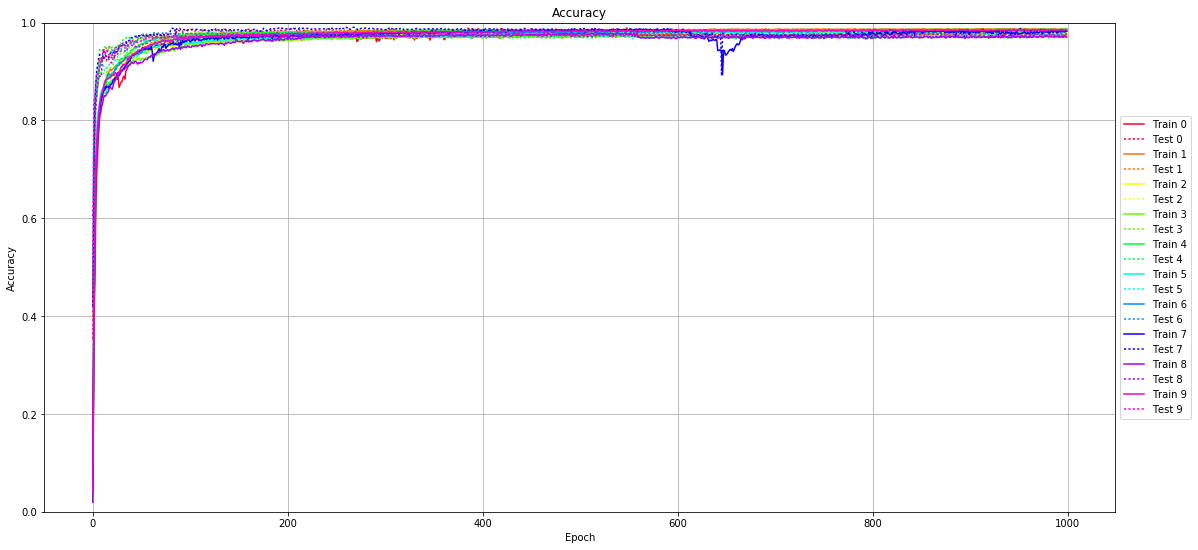

In [15]:
plot_acc(history)

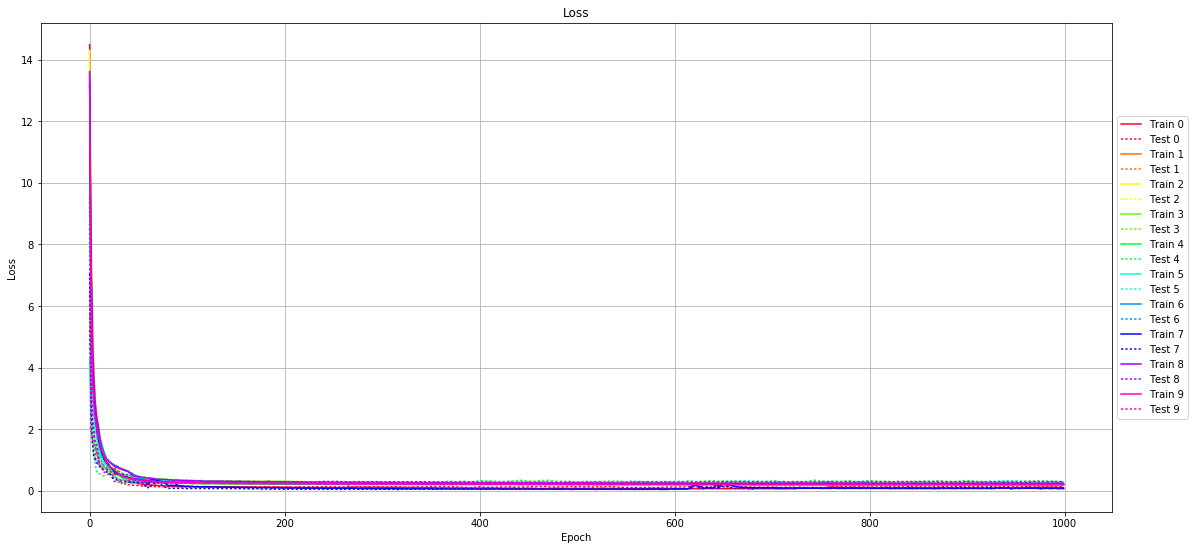

In [16]:
plot_loss(history)

In [17]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


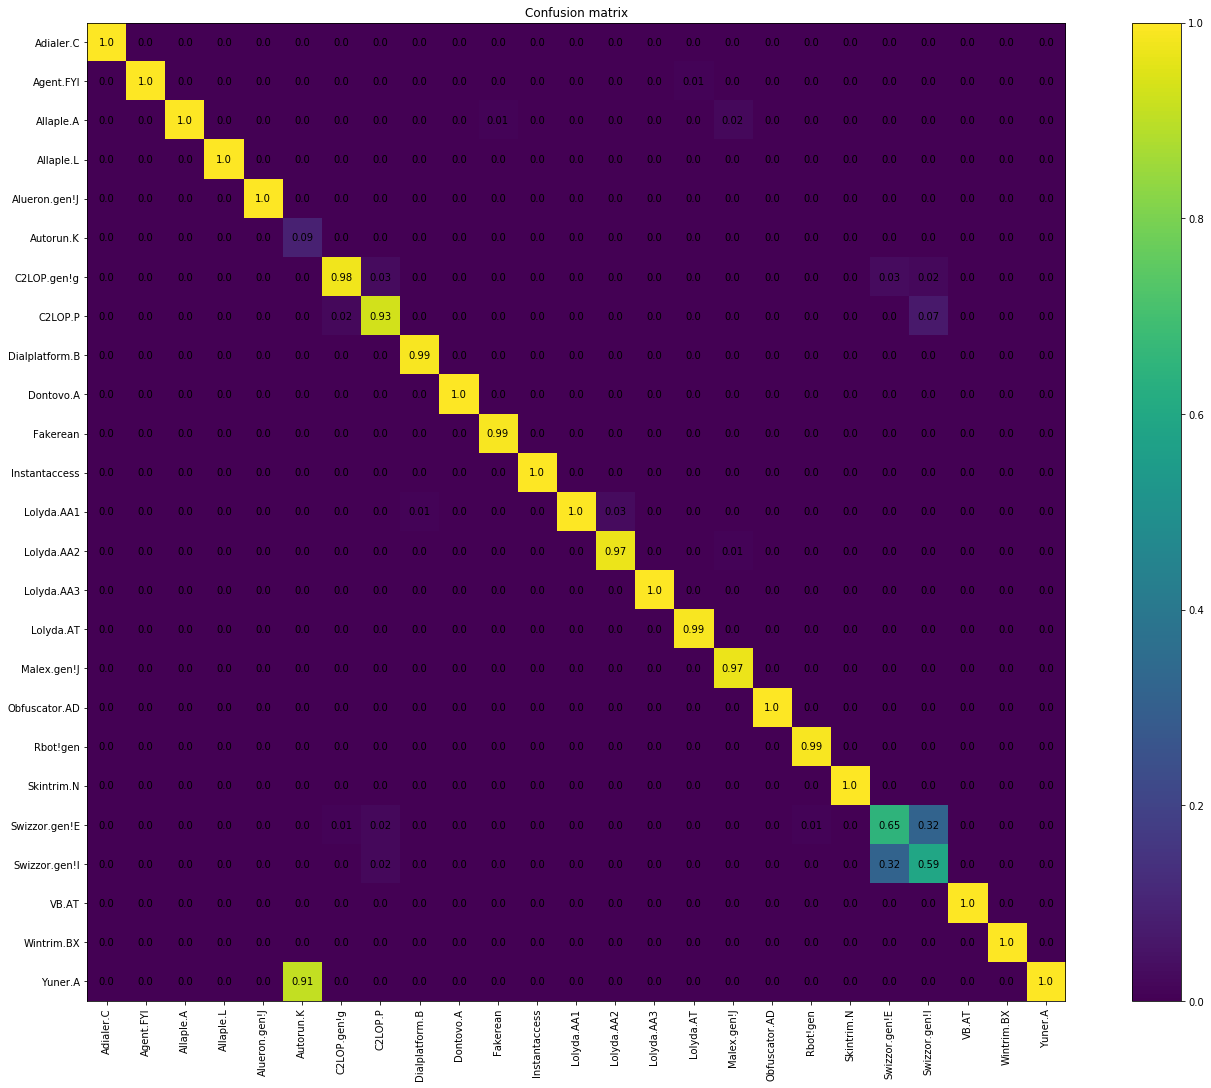

In [18]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()